<a href="https://colab.research.google.com/github/Amirhosein-javadi/Medical-Imaging/blob/main/UNet_Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


To do things: Visualization and without transform

In [2]:
with open('/content/drive/MyDrive/MedicalImage-Team/LiTS17/Info.txt') as f:
  lines = f.readlines()

In [3]:
layer_properties = []

for i in range(2,len(lines)):
    line = lines[i]
    line_split = line.split()
    dana_num = int(line_split[0])
    first_layer = int(line_split[5][1:-1]) 
    last_later = int(line_split[-1][0:-1])
    data_dict = {"dana_num" : dana_num,
                "first_layer" : first_layer,
                "last_layer" : last_later
                }
    layer_properties.append(data_dict)

layer_properties;

#Blocks

## Args

In [4]:
class Args():
    def __init__(self):
        
        self.lr = 0.001
        self.epochs = 50
        self.batch_size = 16
        
        self.alpha = 0.5 #BCE coeff
        self.beta = 0.5 #Dice coeff
        
        self.smooth_weight = 0.01 
        self.seg_weight = 0.5 
        self.loss = 'mse' 
        self.load_model = None
        self.initial_epoch = 0 
        self.int_steps = 7 
        self.int_downsize = 2 
        self.model_dir = './trained-models/torch/1/'

args = Args()

## utils

In [5]:
import importlib
import logging
import os
import shutil
import sys

import h5py
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import optim

plt.ioff()
plt.switch_backend('agg')


def save_checkpoint(state, is_best, checkpoint_dir, logger=None):
    """Saves model and training parameters at '{checkpoint_dir}/last_checkpoint.pytorch'.
    If is_best==True saves '{checkpoint_dir}/best_checkpoint.pytorch' as well.

    Args:
        state (dict): contains model's state_dict, optimizer's state_dict, epoch
            and best evaluation metric value so far
        is_best (bool): if True state contains the best model seen so far
        checkpoint_dir (string): directory where the checkpoint are to be saved
    """

    def log_info(message):
        if logger is not None:
            logger.info(message)

    if not os.path.exists(checkpoint_dir):
        log_info(
            f"Checkpoint directory does not exists. Creating {checkpoint_dir}")
        os.mkdir(checkpoint_dir)

    last_file_path = os.path.join(checkpoint_dir, 'last_checkpoint.pytorch')
    log_info(f"Saving last checkpoint to '{last_file_path}'")
    torch.save(state, last_file_path)
    if is_best:
        best_file_path = os.path.join(checkpoint_dir, 'best_checkpoint.pytorch')
        log_info(f"Saving best checkpoint to '{best_file_path}'")
        shutil.copyfile(last_file_path, best_file_path)


def load_checkpoint(checkpoint_path, model, optimizer=None,
                    model_key='model_state_dict', optimizer_key='optimizer_state_dict'):
    """Loads model and training parameters from a given checkpoint_path
    If optimizer is provided, loads optimizer's state_dict of as well.

    Args:
        checkpoint_path (string): path to the checkpoint to be loaded
        model (torch.nn.Module): model into which the parameters are to be copied
        optimizer (torch.optim.Optimizer) optional: optimizer instance into
            which the parameters are to be copied

    Returns:
        state
    """
    if not os.path.exists(checkpoint_path):
        raise IOError(f"Checkpoint '{checkpoint_path}' does not exist")

    state = torch.load(checkpoint_path, map_location='cpu')
    model.load_state_dict(state[model_key])

    if optimizer is not None:
        optimizer.load_state_dict(state[optimizer_key])

    return state


def save_network_output(output_path, output, logger=None):
    if logger is not None:
        logger.info(f'Saving network output to: {output_path}...')
    output = output.detach().cpu()[0]
    with h5py.File(output_path, 'w') as f:
        f.create_dataset('predictions', data=output, compression='gzip')


loggers = {}


def get_logger(name, level=logging.INFO):
    global loggers
    if loggers.get(name) is not None:
        return loggers[name]
    else:
        logger = logging.getLogger(name)
        logger.setLevel(level)
        # Logging to console
        stream_handler = logging.StreamHandler(sys.stdout)
        formatter = logging.Formatter(
            '%(asctime)s [%(threadName)s] %(levelname)s %(name)s - %(message)s')
        stream_handler.setFormatter(formatter)
        logger.addHandler(stream_handler)

        loggers[name] = logger

        return logger


def get_number_of_learnable_parameters(model):
    model_parameters = filter(lambda p: p.requires_grad, model.parameters())
    return sum([np.prod(p.size()) for p in model_parameters])


class RunningAverage:
    """Computes and stores the average
    """

    def __init__(self):
        self.count = 0
        self.sum = 0
        self.avg = 0

    def update(self, value, n=1):
        self.count += n
        self.sum += value * n
        self.avg = self.sum / self.count


def find_maximum_patch_size(model, device):
    """Tries to find the biggest patch size that can be send to GPU for inference
    without throwing CUDA out of memory"""
    logger = get_logger('PatchFinder')
    in_channels = model.in_channels

    patch_shapes = [(64, 128, 128), (96, 128, 128),
                    (64, 160, 160), (96, 160, 160),
                    (64, 192, 192), (96, 192, 192)]

    for shape in patch_shapes:
        # generate random patch of a given size
        patch = np.random.randn(*shape).astype('float32')

        patch = torch \
            .from_numpy(patch) \
            .view((1, in_channels) + patch.shape) \
            .to(device)

        logger.info(f"Current patch size: {shape}")
        model(patch)


def remove_halo(patch, index, shape, patch_halo):
    """
    Remove `pad_width` voxels around the edges of a given patch.
    """
    assert len(patch_halo) == 3

    def _new_slices(slicing, max_size, pad):
        if slicing.start == 0:
            p_start = 0
            i_start = 0
        else:
            p_start = pad
            i_start = slicing.start + pad

        if slicing.stop == max_size:
            p_stop = None
            i_stop = max_size
        else:
            p_stop = -pad if pad != 0 else 1
            i_stop = slicing.stop - pad

        return slice(p_start, p_stop), slice(i_start, i_stop)

    D, H, W = shape

    i_c, i_z, i_y, i_x = index
    p_c = slice(0, patch.shape[0])

    p_z, i_z = _new_slices(i_z, D, patch_halo[0])
    p_y, i_y = _new_slices(i_y, H, patch_halo[1])
    p_x, i_x = _new_slices(i_x, W, patch_halo[2])

    patch_index = (p_c, p_z, p_y, p_x)
    index = (i_c, i_z, i_y, i_x)
    return patch[patch_index], index


def number_of_features_per_level(init_channel_number, num_levels):
    return [init_channel_number * 2 ** k for k in range(num_levels)]


class _TensorboardFormatter:
    """
    Tensorboard formatters converts a given batch of images (be it input/output to the network or the target segmentation
    image) to a series of images that can be displayed in tensorboard. This is the parent class for all tensorboard
    formatters which ensures that returned images are in the 'CHW' format.
    """

    def __init__(self, **kwargs):
        pass

    def __call__(self, name, batch):
        """
        Transform a batch to a series of tuples of the form (tag, img), where `tag` corresponds to the image tag
        and `img` is the image itself.

        Args:
             name (str): one of 'inputs'/'targets'/'predictions'
             batch (torch.tensor): 4D or 5D torch tensor
        """

        def _check_img(tag_img):
            tag, img = tag_img

            assert img.ndim == 2 or img.ndim == 3, 'Only 2D (HW) and 3D (CHW) images are accepted for display'

            if img.ndim == 2:
                img = np.expand_dims(img, axis=0)
            else:
                C = img.shape[0]
                assert C == 1 or C == 3, 'Only (1, H, W) or (3, H, W) images are supported'

            return tag, img

        tagged_images = self.process_batch(name, batch)

        return list(map(_check_img, tagged_images))

    def process_batch(self, name, batch):
        raise NotImplementedError


class DefaultTensorboardFormatter(_TensorboardFormatter):
    def __init__(self, skip_last_target=False, **kwargs):
        super().__init__(**kwargs)
        self.skip_last_target = skip_last_target

    def process_batch(self, name, batch):
        if name == 'targets' and self.skip_last_target:
            batch = batch[:, :-1, ...]

        tag_template = '{}/batch_{}/channel_{}/slice_{}'

        tagged_images = []

        if batch.ndim == 5:
            # NCDHW
            slice_idx = batch.shape[2] // 2  # get the middle slice
            for batch_idx in range(batch.shape[0]):
                for channel_idx in range(batch.shape[1]):
                    tag = tag_template.format(name, batch_idx, channel_idx, slice_idx)
                    img = batch[batch_idx, channel_idx, slice_idx, ...]
                    tagged_images.append((tag, self._normalize_img(img)))
        else:
            # batch has no channel dim: NDHW
            slice_idx = batch.shape[1] // 2  # get the middle slice
            for batch_idx in range(batch.shape[0]):
                tag = tag_template.format(name, batch_idx, 0, slice_idx)
                img = batch[batch_idx, slice_idx, ...]
                tagged_images.append((tag, self._normalize_img(img)))

        return tagged_images

    @staticmethod
    def _normalize_img(img):
        return np.nan_to_num((img - np.min(img)) / np.ptp(img))


def _find_masks(batch, min_size=10):
    """Center the z-slice in the 'middle' of a given instance, given a batch of instances

    Args:
        batch (ndarray): 5d numpy tensor (NCDHW)
    """
    result = []
    for b in batch:
        assert b.shape[0] == 1
        patch = b[0]
        z_sum = patch.sum(axis=(1, 2))
        coords = np.where(z_sum > min_size)[0]
        if len(coords) > 0:
            ind = coords[len(coords) // 2]
            result.append(b[:, ind:ind + 1, ...])
        else:
            ind = b.shape[1] // 2
            result.append(b[:, ind:ind + 1, ...])

    return np.stack(result, axis=0)


def get_tensorboard_formatter(config):
    if config is None:
        return DefaultTensorboardFormatter()

    class_name = config['name']
    m = importlib.import_module('pytorch3dunet.unet3d.utils')
    clazz = getattr(m, class_name)
    return clazz(**config)


def expand_as_one_hot(input, C, ignore_index=None):
    """
    Converts NxSPATIAL label image to NxCxSPATIAL, where each label gets converted to its corresponding one-hot vector.
    It is assumed that the batch dimension is present.
    Args:
        input (torch.Tensor): 3D/4D input image
        C (int): number of channels/labels
        ignore_index (int): ignore index to be kept during the expansion
    Returns:
        4D/5D output torch.Tensor (NxCxSPATIAL)
    """
    assert input.dim() == 4

    # expand the input tensor to Nx1xSPATIAL before scattering
    input = input.unsqueeze(1)
    # create output tensor shape (NxCxSPATIAL)
    shape = list(input.size())
    shape[1] = C

    if ignore_index is not None:
        # create ignore_index mask for the result
        mask = input.expand(shape) == ignore_index
        # clone the src tensor and zero out ignore_index in the input
        input = input.clone()
        input[input == ignore_index] = 0
        # scatter to get the one-hot tensor
        result = torch.zeros(shape).to(input.device).scatter_(1, input, 1)
        # bring back the ignore_index in the result
        result[mask] = ignore_index
        return result
    else:
        # scatter to get the one-hot tensor
        return torch.zeros(shape).to(input.device).scatter_(1, input, 1)


def convert_to_numpy(*inputs):
    """
    Coverts input tensors to numpy ndarrays

    Args:
        inputs (iteable of torch.Tensor): torch tensor

    Returns:
        tuple of ndarrays
    """

    def _to_numpy(i):
        assert isinstance(i, torch.Tensor), "Expected input to be torch.Tensor"
        return i.detach().cpu().numpy()

    return (_to_numpy(i) for i in inputs)


def create_optimizer(optimizer_config, model):
    learning_rate = optimizer_config['learning_rate']
    weight_decay = optimizer_config.get('weight_decay', 0)
    betas = tuple(optimizer_config.get('betas', (0.9, 0.999)))
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, betas=betas, weight_decay=weight_decay)
    return optimizer


def create_lr_scheduler(lr_config, optimizer):
    if lr_config is None:
        return None
    class_name = lr_config.pop('name')
    m = importlib.import_module('torch.optim.lr_scheduler')
    clazz = getattr(m, class_name)
    # add optimizer to the config
    lr_config['optimizer'] = optimizer
    return clazz(**lr_config)


def create_sample_plotter(sample_plotter_config):
    if sample_plotter_config is None:
        return None
    class_name = sample_plotter_config['name']
    m = importlib.import_module('pytorch3dunet.unet3d.utils')
    clazz = getattr(m, class_name)
    return clazz(**sample_plotter_config)


## buildingblocks

In [6]:
from functools import partial

import torch
from torch import nn as nn
from torch.nn import functional as F


def conv3d(in_channels, out_channels, kernel_size, bias, padding):
    return nn.Conv3d(in_channels, out_channels, kernel_size, padding=padding, bias=bias)


def create_conv(in_channels, out_channels, kernel_size, order, num_groups, padding):
    """
    Create a list of modules with together constitute a single conv layer with non-linearity
    and optional batchnorm/groupnorm.

    Args:
        in_channels (int): number of input channels
        out_channels (int): number of output channels
        kernel_size(int or tuple): size of the convolving kernel
        order (string): order of things, e.g.
            'cr' -> conv + ReLU
            'gcr' -> groupnorm + conv + ReLU
            'cl' -> conv + LeakyReLU
            'ce' -> conv + ELU
            'bcr' -> batchnorm + conv + ReLU
        num_groups (int): number of groups for the GroupNorm
        padding (int or tuple): add zero-padding added to all three sides of the input

    Return:
        list of tuple (name, module)
    """
    assert 'c' in order, "Conv layer MUST be present"
    assert order[0] not in 'rle', 'Non-linearity cannot be the first operation in the layer'

    modules = []
    for i, char in enumerate(order):
        if char == 'r':
            modules.append(('ReLU', nn.ReLU(inplace=True)))
        elif char == 'l':
            modules.append(('LeakyReLU', nn.LeakyReLU(inplace=True)))
        elif char == 'e':
            modules.append(('ELU', nn.ELU(inplace=True)))
        elif char == 'c':
            # add learnable bias only in the absence of batchnorm/groupnorm
            bias = not ('g' in order or 'b' in order)
            modules.append(('conv', conv3d(in_channels, out_channels, kernel_size, bias, padding=padding)))
        elif char == 'g':
            is_before_conv = i < order.index('c')
            if is_before_conv:
                num_channels = in_channels
            else:
                num_channels = out_channels

            # use only one group if the given number of groups is greater than the number of channels
            if num_channels < num_groups:
                num_groups = 1

            assert num_channels % num_groups == 0, f'Expected number of channels in input to be divisible by num_groups. num_channels={num_channels}, num_groups={num_groups}'
            modules.append(('groupnorm', nn.GroupNorm(num_groups=num_groups, num_channels=num_channels)))
        elif char == 'b':
            is_before_conv = i < order.index('c')
            if is_before_conv:
                modules.append(('batchnorm', nn.BatchNorm3d(in_channels)))
            else:
                modules.append(('batchnorm', nn.BatchNorm3d(out_channels)))
        else:
            raise ValueError(f"Unsupported layer type '{char}'. MUST be one of ['b', 'g', 'r', 'l', 'e', 'c']")

    return modules


class SingleConv(nn.Sequential):
    """
    Basic convolutional module consisting of a Conv3d, non-linearity and optional batchnorm/groupnorm. The order
    of operations can be specified via the `order` parameter

    Args:
        in_channels (int): number of input channels
        out_channels (int): number of output channels
        kernel_size (int or tuple): size of the convolving kernel
        order (string): determines the order of layers, e.g.
            'cr' -> conv + ReLU
            'crg' -> conv + ReLU + groupnorm
            'cl' -> conv + LeakyReLU
            'ce' -> conv + ELU
        num_groups (int): number of groups for the GroupNorm
        padding (int or tuple):
    """

    def __init__(self, in_channels, out_channels, kernel_size=3, order='gcr', num_groups=8, padding=1):
        super(SingleConv, self).__init__()

        for name, module in create_conv(in_channels, out_channels, kernel_size, order, num_groups, padding=padding):
            self.add_module(name, module)


class DoubleConv(nn.Sequential):
    """
    A module consisting of two consecutive convolution layers (e.g. BatchNorm3d+ReLU+Conv3d).
    We use (Conv3d+ReLU+GroupNorm3d) by default.
    This can be changed however by providing the 'order' argument, e.g. in order
    to change to Conv3d+BatchNorm3d+ELU use order='cbe'.
    Use padded convolutions to make sure that the output (H_out, W_out) is the same
    as (H_in, W_in), so that you don't have to crop in the decoder path.

    Args:
        in_channels (int): number of input channels
        out_channels (int): number of output channels
        encoder (bool): if True we're in the encoder path, otherwise we're in the decoder
        kernel_size (int or tuple): size of the convolving kernel
        order (string): determines the order of layers, e.g.
            'cr' -> conv + ReLU
            'crg' -> conv + ReLU + groupnorm
            'cl' -> conv + LeakyReLU
            'ce' -> conv + ELU
        num_groups (int): number of groups for the GroupNorm
        padding (int or tuple): add zero-padding added to all three sides of the input
    """

    def __init__(self, in_channels, out_channels, encoder, kernel_size=3, order='gcr', num_groups=8, padding=1):
        super(DoubleConv, self).__init__()
        if encoder:
            # we're in the encoder path
            conv1_in_channels = in_channels
            conv1_out_channels = out_channels // 2
            if conv1_out_channels < in_channels:
                conv1_out_channels = in_channels
            conv2_in_channels, conv2_out_channels = conv1_out_channels, out_channels
        else:
            # we're in the decoder path, decrease the number of channels in the 1st convolution
            conv1_in_channels, conv1_out_channels = in_channels, out_channels
            conv2_in_channels, conv2_out_channels = out_channels, out_channels

        # conv1
        self.add_module('SingleConv1',
                        SingleConv(conv1_in_channels, conv1_out_channels, kernel_size, order, num_groups,
                                   padding=padding))
        # conv2
        self.add_module('SingleConv2',
                        SingleConv(conv2_in_channels, conv2_out_channels, kernel_size, order, num_groups,
                                   padding=padding))


class ExtResNetBlock(nn.Module):
    """
    Basic UNet block consisting of a SingleConv followed by the residual block.
    The SingleConv takes care of increasing/decreasing the number of channels and also ensures that the number
    of output channels is compatible with the residual block that follows.
    This block can be used instead of standard DoubleConv in the Encoder module.
    Motivated by: https://arxiv.org/pdf/1706.00120.pdf

    Notice we use ELU instead of ReLU (order='cge') and put non-linearity after the groupnorm.
    """

    def __init__(self, in_channels, out_channels, kernel_size=3, order='cge', num_groups=8, **kwargs):
        super(ExtResNetBlock, self).__init__()

        # first convolution
        self.conv1 = SingleConv(in_channels, out_channels, kernel_size=kernel_size, order=order, num_groups=num_groups)
        # residual block
        self.conv2 = SingleConv(out_channels, out_channels, kernel_size=kernel_size, order=order, num_groups=num_groups)
        # remove non-linearity from the 3rd convolution since it's going to be applied after adding the residual
        n_order = order
        for c in 'rel':
            n_order = n_order.replace(c, '')
        self.conv3 = SingleConv(out_channels, out_channels, kernel_size=kernel_size, order=n_order,
                                num_groups=num_groups)

        # create non-linearity separately
        if 'l' in order:
            self.non_linearity = nn.LeakyReLU(negative_slope=0.1, inplace=True)
        elif 'e' in order:
            self.non_linearity = nn.ELU(inplace=True)
        else:
            self.non_linearity = nn.ReLU(inplace=True)

    def forward(self, x):
        # apply first convolution and save the output as a residual
        out = self.conv1(x)
        residual = out
        #print("out1" , out.shape)

        # residual block
        out = self.conv2(out)
        #print("out2" , out.shape)

        out = self.conv3(out)
        #print("out3" , out.shape)

        out += residual
        out = self.non_linearity(out)

        return out


class Encoder(nn.Module):
    """
    A single module from the encoder path consisting of the optional max
    pooling layer (one may specify the MaxPool kernel_size to be different
    than the standard (2,2,2), e.g. if the volumetric data is anisotropic
    (make sure to use complementary scale_factor in the decoder path) followed by
    a DoubleConv module.
    Args:
        in_channels (int): number of input channels
        out_channels (int): number of output channels
        conv_kernel_size (int or tuple): size of the convolving kernel
        apply_pooling (bool): if True use MaxPool3d before DoubleConv
        pool_kernel_size (int or tuple): the size of the window
        pool_type (str): pooling layer: 'max' or 'avg'
        basic_module(nn.Module): either ResNetBlock or DoubleConv
        conv_layer_order (string): determines the order of layers
            in `DoubleConv` module. See `DoubleConv` for more info.
        num_groups (int): number of groups for the GroupNorm
        padding (int or tuple): add zero-padding added to all three sides of the input
    """

    def __init__(self, in_channels, out_channels, conv_kernel_size=3, apply_pooling=True,
                 pool_kernel_size=2, pool_type='max', basic_module=DoubleConv, conv_layer_order='gcr',
                 num_groups=8, padding=1):
        super(Encoder, self).__init__()
        assert pool_type in ['max', 'avg']
        if apply_pooling:
            if pool_type == 'max':
                self.pooling = nn.MaxPool3d(kernel_size=pool_kernel_size)
            else:
                self.pooling = nn.AvgPool3d(kernel_size=pool_kernel_size)
        else:
            self.pooling = None

        self.basic_module = basic_module(in_channels, out_channels,
                                         encoder=True,
                                         kernel_size=conv_kernel_size,
                                         order=conv_layer_order,
                                         num_groups=num_groups,
                                         padding=padding)

    def forward(self, x):
        if self.pooling is not None:
            x = self.pooling(x)
        x = self.basic_module(x)
        return x


class Decoder(nn.Module):
    """
    A single module for decoder path consisting of the upsampling layer
    (either learned ConvTranspose3d or nearest neighbor interpolation) followed by a basic module (DoubleConv or ExtResNetBlock).
    Args:
        in_channels (int): number of input channels
        out_channels (int): number of output channels
        conv_kernel_size (int or tuple): size of the convolving kernel
        scale_factor (tuple): used as the multiplier for the image H/W/D in
            case of nn.Upsample or as stride in case of ConvTranspose3d, must reverse the MaxPool3d operation
            from the corresponding encoder
        basic_module(nn.Module): either ResNetBlock or DoubleConv
        conv_layer_order (string): determines the order of layers
            in `DoubleConv` module. See `DoubleConv` for more info.
        num_groups (int): number of groups for the GroupNorm
        padding (int or tuple): add zero-padding added to all three sides of the input
        upsample (boole): should the input be upsampled
    """

    def __init__(self, in_channels, out_channels, conv_kernel_size=3, scale_factor=(2, 2, 2), basic_module=DoubleConv,
                 conv_layer_order='gcr', num_groups=8, mode='nearest', padding=1, upsample=True):
        super(Decoder, self).__init__()

        if upsample:
            if basic_module == DoubleConv:
                # if DoubleConv is the basic_module use interpolation for upsampling and concatenation joining
                self.upsampling = InterpolateUpsampling(mode=mode)
                # concat joining
                self.joining = partial(self._joining, concat=True)
            else:
                # if basic_module=ExtResNetBlock use transposed convolution upsampling and summation joining
                self.upsampling = TransposeConvUpsampling(in_channels=in_channels, out_channels=out_channels,
                                                          kernel_size=conv_kernel_size, scale_factor=scale_factor)
                # sum joining
                self.joining = partial(self._joining, concat=False)
                # adapt the number of in_channels for the ExtResNetBlock
                in_channels = out_channels
        else:
            # no upsampling
            self.upsampling = NoUpsampling()
            # concat joining
            self.joining = partial(self._joining, concat=True)

        self.basic_module = basic_module(in_channels, out_channels,
                                         encoder=False,
                                         kernel_size=conv_kernel_size,
                                         order=conv_layer_order,
                                         num_groups=num_groups,
                                         padding=padding)

    def forward(self, encoder_features, x):
        x = self.upsampling(encoder_features=encoder_features, x=x)
        #print("upsampling:" , x.shape)
        x = self.joining(encoder_features, x)
        #print("joining:" , x.shape)
        x = self.basic_module(x)
        #print("basic_module" , x.shape)
        return x

    @staticmethod
    def _joining(encoder_features, x, concat):
        if concat:
            return torch.cat((encoder_features, x), dim=1)
        else:
            return encoder_features + x


def create_encoders(in_channels, f_maps, basic_module, conv_kernel_size, conv_padding, layer_order, num_groups,
                    pool_kernel_size):
    # create encoder path consisting of Encoder modules. Depth of the encoder is equal to `len(f_maps)`
    encoders = []
    for i, out_feature_num in enumerate(f_maps):
        if i == 0:
            encoder = Encoder(in_channels, out_feature_num,
                              apply_pooling=False,  # skip pooling in the firs encoder
                              basic_module=basic_module,
                              conv_layer_order=layer_order,
                              conv_kernel_size=conv_kernel_size,
                              num_groups=num_groups,
                              padding=conv_padding)
            
        else:
            # TODO: adapt for anisotropy in the data, i.e. use proper pooling kernel to make the data isotropic after 1-2 pooling operations
            encoder = Encoder(f_maps[i - 1], out_feature_num,
                              basic_module=basic_module,
                              conv_layer_order=layer_order,
                              conv_kernel_size=conv_kernel_size,
                              num_groups=num_groups,
                              pool_kernel_size=pool_kernel_size,
                              padding=conv_padding)

        encoders.append(encoder)

    return nn.ModuleList(encoders)


def create_decoders(f_maps, basic_module, conv_kernel_size, conv_padding, layer_order, num_groups, upsample):
    # create decoder path consisting of the Decoder modules. The length of the decoder list is equal to `len(f_maps) - 1`
    decoders = []
    reversed_f_maps = list(reversed(f_maps))
    for i in range(len(reversed_f_maps) - 1):
        if basic_module == DoubleConv:
            in_feature_num = reversed_f_maps[i] + reversed_f_maps[i + 1]
        else:
            in_feature_num = reversed_f_maps[i]

        out_feature_num = reversed_f_maps[i + 1]

        # TODO: if non-standard pooling was used, make sure to use correct striding for transpose conv
        # currently strides with a constant stride: (2, 2, 2)

        _upsample = True
        if i == 0:
            # upsampling can be skipped only for the 1st decoder, afterwards it should always be present
            _upsample = upsample

        decoder = Decoder(in_feature_num, out_feature_num,
                          basic_module=basic_module,
                          conv_layer_order=layer_order,
                          conv_kernel_size=conv_kernel_size,
                          num_groups=num_groups,
                          padding=conv_padding,
                          upsample=_upsample)
        decoders.append(decoder)
    return nn.ModuleList(decoders)


class AbstractUpsampling(nn.Module):
    """
    Abstract class for upsampling. A given implementation should upsample a given 5D input tensor using either
    interpolation or learned transposed convolution.
    """

    def __init__(self, upsample):
        super(AbstractUpsampling, self).__init__()
        self.upsample = upsample

    def forward(self, encoder_features, x):
        # get the spatial dimensions of the output given the encoder_features
        output_size = encoder_features.size()[2:]
        # upsample the input and return
        return self.upsample(x, output_size)


class InterpolateUpsampling(AbstractUpsampling):
    """
    Args:
        mode (str): algorithm used for upsampling:
            'nearest' | 'linear' | 'bilinear' | 'trilinear' | 'area'. Default: 'nearest'
            used only if transposed_conv is False
    """

    def __init__(self, mode='nearest'):
        upsample = partial(self._interpolate, mode=mode)
        super().__init__(upsample)

    @staticmethod
    def _interpolate(x, size, mode):
        return F.interpolate(x, size=size, mode=mode)


class TransposeConvUpsampling(AbstractUpsampling):
    """
    Args:
        in_channels (int): number of input channels for transposed conv
            used only if transposed_conv is True
        out_channels (int): number of output channels for transpose conv
            used only if transposed_conv is True
        kernel_size (int or tuple): size of the convolving kernel
            used only if transposed_conv is True
        scale_factor (int or tuple): stride of the convolution
            used only if transposed_conv is True

    """

    def __init__(self, in_channels=None, out_channels=None, kernel_size=3, scale_factor=(2, 2, 2)):
        # make sure that the output size reverses the MaxPool3d from the corresponding encoder
        upsample = nn.ConvTranspose3d(in_channels, out_channels, kernel_size=kernel_size, stride=scale_factor,
                                      padding=1)
        super().__init__(upsample)


class NoUpsampling(AbstractUpsampling):
    def __init__(self):
        super().__init__(self._no_upsampling)

    @staticmethod
    def _no_upsampling(x, size):
        return x

## Loss

In [7]:
import torch
import torch.nn.functional as F
from torch import nn as nn
from torch.autograd import Variable
from torch.nn import MSELoss, SmoothL1Loss, L1Loss

# from utils import expand_as_one_hot


def compute_per_channel_dice(input, target, epsilon=1e-6, weight=None):
    """
    Computes DiceCoefficient as defined in https://arxiv.org/abs/1606.04797 given  a multi channel input and target.
    Assumes the input is a normalized probability, e.g. a result of Sigmoid or Softmax function.

    Args:
         input (torch.Tensor): NxCxSpatial input tensor   
         target (torch.Tensor): NxCxSpatial target tensor
         epsilon (float): prevents division by zero
         weight (torch.Tensor): Cx1 tensor of weight per channel/class
    """

    # input and target shapes must match
    assert input.size() == target.size(), "'input' and 'target' must have the same shape"

    input = flatten(input)
    target = flatten(target)
    target = target.float()

    # compute per channel Dice Coefficient
    intersect = (input * target).sum(-1)
    if weight is not None:
        intersect = weight * intersect

    # here we can use standard dice (input + target).sum(-1) or extension (see V-Net) (input^2 + target^2).sum(-1)
    denominator = (input * input).sum(-1) + (target * target).sum(-1)

    intersect = intersect.clamp(min=epsilon/2)
    denominator = denominator.clamp(min=epsilon)
    return 2 * intersect / denominator


class _MaskingLossWrapper(nn.Module):
    """
    Loss wrapper which prevents the gradient of the loss to be computed where target is equal to `ignore_index`.
    """

    def __init__(self, loss, ignore_index):
        super(_MaskingLossWrapper, self).__init__()
        assert ignore_index is not None, 'ignore_index cannot be None'
        self.loss = loss
        self.ignore_index = ignore_index

    def forward(self, input, target):
        mask = target.clone().ne_(self.ignore_index)
        mask.requires_grad = False

        # mask out input/target so that the gradient is zero where on the mask
        input = input * mask
        target = target * mask

        # forward masked input and target to the loss
        return self.loss(input, target)


class SkipLastTargetChannelWrapper(nn.Module):
    """
    Loss wrapper which removes additional target channel
    """

    def __init__(self, loss, squeeze_channel=False):
        super(SkipLastTargetChannelWrapper, self).__init__()
        self.loss = loss
        self.squeeze_channel = squeeze_channel

    def forward(self, input, target):
        assert target.size(1) > 1, 'Target tensor has a singleton channel dimension, cannot remove channel'

        # skips last target channel if needed
        target = target[:, :-1, ...]

        if self.squeeze_channel:
            # squeeze channel dimension if singleton
            target = torch.squeeze(target, dim=1)
        return self.loss(input, target)


class _AbstractDiceLoss(nn.Module):
    """
    Base class for different implementations of Dice loss.
    """

    def __init__(self, weight=None, normalization='sigmoid'):
        super(_AbstractDiceLoss, self).__init__()
        self.register_buffer('weight', weight)
        # The output from the network during training is assumed to be un-normalized probabilities and we would
        # like to normalize the logits. Since Dice (or soft Dice in this case) is usually used for binary data,
        # normalizing the channels with Sigmoid is the default choice even for multi-class segmentation problems.
        # However if one would like to apply Softmax in order to get the proper probability distribution from the
        # output, just specify `normalization=Softmax`
        assert normalization in ['sigmoid', 'softmax', 'none']
        if normalization == 'sigmoid':
            self.normalization = nn.Sigmoid()
        elif normalization == 'softmax':
            self.normalization = nn.Softmax(dim=1)
        else:
            self.normalization = lambda x: x

    def dice(self, input, target, weight):
        # actual Dice score computation; to be implemented by the subclass
        raise NotImplementedError

    def forward(self, input, target):
        # get probabilities from logits
        input = self.normalization(input)

        # compute per channel Dice coefficient
        per_channel_dice = self.dice(input, target, weight=self.weight)
        # average Dice score across all channels/classes
        return 1. - torch.mean(per_channel_dice)


class DiceLoss(_AbstractDiceLoss):
    """Computes Dice Loss according to https://arxiv.org/abs/1606.04797.
    For multi-class segmentation `weight` parameter can be used to assign different weights per class.
    The input to the loss function is assumed to be a logit and will be normalized by the Sigmoid function.
    """

    def __init__(self, weight=None, normalization='sigmoid'):
        super().__init__(weight, normalization)

    def dice(self, input, target, weight):
        return compute_per_channel_dice(input, target, weight=self.weight)[0]


class GeneralizedDiceLoss(_AbstractDiceLoss):
    """Computes Generalized Dice Loss (GDL) as described in https://arxiv.org/pdf/1707.03237.pdf.
    """

    def __init__(self, normalization='sigmoid', epsilon=1e-6):
        super().__init__(weight=None, normalization=normalization)
        self.epsilon = epsilon

    def dice(self, input, target, weight):
        assert input.size() == target.size(), "'input' and 'target' must have the same shape"

        input = flatten(input)
        target = flatten(target)
        target = target.float()

        if input.size(0) == 1:
            # for GDL to make sense we need at least 2 channels (see https://arxiv.org/pdf/1707.03237.pdf)
            # put foreground and background voxels in separate channels
            input = torch.cat((input, 1 - input), dim=0)
            target = torch.cat((target, 1 - target), dim=0)

        # GDL weighting: the contribution of each label is corrected by the inverse of its volume
        w_l = target.sum(-1)
        w_l = 1 / (w_l * w_l).clamp(min=self.epsilon)
        w_l.requires_grad = False

        intersect = (input * target).sum(-1)
        intersect = intersect * w_l

        denominator = (input + target).sum(-1)
        denominator = (denominator * w_l).clamp(min=self.epsilon)

        return 2 * (intersect.sum() / denominator.sum())


def focal_loss(bce_loss, targets, gamma, alpha):
    """Binary focal loss, mean.

    Per https://discuss.pytorch.org/t/is-this-a-correct-implementation-for-focal-loss-in-pytorch/43327/5 with
    improvements for alpha.
    :param bce_loss: Binary Cross Entropy loss, a torch tensor.
    :param targets: a torch tensor containing the ground truth, 0s and 1s.
    :param gamma: focal loss power parameter, a float scalar.
    :param alpha: weight of the class indicated by 1, a float scalar.
    """
    p_t = torch.exp(-bce_loss)
    alpha_tensor = (1 - alpha) + targets * (2 * alpha - 1)  # alpha if target = 1 and 1 - alpha if target = 0
    f_loss = alpha_tensor * (1 - p_t) ** gamma * bce_loss
    return f_loss.mean()


class BCEDiceLoss(nn.Module):
    """Linear combination of BCE and Dice losses"""

    def __init__(self, alpha, beta):
        super(BCEDiceLoss, self).__init__()
        self.alpha = alpha
        self.bce = nn.BCEWithLogitsLoss()
        self.beta = beta
        self.dice = DiceLoss()
        self.mse = MSELoss()
        

    def forward(self, input, target):
        return self.alpha * self.bce(input, target) + self.beta * self.dice(input, target) # + focal_loss(self.bce(input, target) , target , gamma = 0.5 , alpha = 0.3)


class WeightedCrossEntropyLoss(nn.Module):
    """WeightedCrossEntropyLoss (WCE) as described in https://arxiv.org/pdf/1707.03237.pdf
    """

    def __init__(self, ignore_index=-1):
        super(WeightedCrossEntropyLoss, self).__init__()
        self.ignore_index = ignore_index

    def forward(self, input, target):
        weight = self._class_weights(input)
        return F.cross_entropy(input, target, weight=weight, ignore_index=self.ignore_index)

    @staticmethod
    def _class_weights(input):
        # normalize the input first
        input = F.softmax(input, dim=1)
        flattened = flatten(input)
        nominator = (1. - flattened).sum(-1)
        denominator = flattened.sum(-1)
        class_weights = Variable(nominator / denominator, requires_grad=False)
        return class_weights


class PixelWiseCrossEntropyLoss(nn.Module):
    def __init__(self, class_weights=None, ignore_index=None):
        super(PixelWiseCrossEntropyLoss, self).__init__()
        self.register_buffer('class_weights', class_weights)
        self.ignore_index = ignore_index
        self.log_softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, target, weights):
        assert target.size() == weights.size()
        # normalize the input
        log_probabilities = self.log_softmax(input)
        # standard CrossEntropyLoss requires the target to be (NxDxHxW), so we need to expand it to (NxCxDxHxW)
        target = expand_as_one_hot(target, C=input.size()[1], ignore_index=self.ignore_index)
        # expand weights
        weights = weights.unsqueeze(1)
        weights = weights.expand_as(input)

        # create default class_weights if None
        if self.class_weights is None:
            class_weights = torch.ones(input.size()[1]).float().to(input.device)
        else:
            class_weights = self.class_weights

        # resize class_weights to be broadcastable into the weights
        class_weights = class_weights.view(1, -1, 1, 1, 1)

        # multiply weights tensor by class weights
        weights = class_weights * weights

        # compute the losses
        result = -weights * target * log_probabilities
        # average the losses
        return result.mean()


class WeightedSmoothL1Loss(nn.SmoothL1Loss):
    def __init__(self, threshold, initial_weight, apply_below_threshold=True):
        super().__init__(reduction="none")
        self.threshold = threshold
        self.apply_below_threshold = apply_below_threshold
        self.weight = initial_weight

    def forward(self, input, target):
        l1 = super().forward(input, target)

        if self.apply_below_threshold:
            mask = target < self.threshold
        else:
            mask = target >= self.threshold

        l1[mask] = l1[mask] * self.weight

        return l1.mean()


def flatten(tensor):
    """Flattens a given tensor such that the channel axis is first.
    The shapes are transformed as follows:
       (N, C, D, H, W) -> (C, N * D * H * W)
    """
    # number of channels
    C = tensor.size(1)
    # new axis order
    axis_order = (1, 0) + tuple(range(2, tensor.dim()))
    # Transpose: (N, C, D, H, W) -> (C, N, D, H, W)
    transposed = tensor.permute(axis_order)
    # Flatten: (C, N, D, H, W) -> (C, N * D * H * W)
    return transposed.contiguous().view(C, -1)


def get_loss_criterion(config):
    """
    Returns the loss function based on provided configuration
    :param config: (dict) a top level configuration object containing the 'loss' key
    :return: an instance of the loss function
    """
    assert 'loss' in config, 'Could not find loss function configuration'
    loss_config = config['loss']
    name = loss_config.pop('name')

    ignore_index = loss_config.pop('ignore_index', None)
    skip_last_target = loss_config.pop('skip_last_target', False)
    weight = loss_config.pop('weight', None)

    if weight is not None:
        # convert to cuda tensor if necessary
        weight = torch.tensor(weight).to(config['device'])

    pos_weight = loss_config.pop('pos_weight', None)
    if pos_weight is not None:
        # convert to cuda tensor if necessary
        pos_weight = torch.tensor(pos_weight).to(config['device'])

    loss = _create_loss(name, loss_config, weight, ignore_index, pos_weight)

    if not (ignore_index is None or name in ['CrossEntropyLoss', 'WeightedCrossEntropyLoss']):
        # use MaskingLossWrapper only for non-cross-entropy losses, since CE losses allow specifying 'ignore_index' directly
        loss = _MaskingLossWrapper(loss, ignore_index)

    if skip_last_target:
        loss = SkipLastTargetChannelWrapper(loss, loss_config.get('squeeze_channel', False))

    return loss


#######################################################################################################################

def create_loss(name, loss_config, weight, ignore_index, pos_weight):
    if name == 'BCEWithLogitsLoss':
        return nn.BCEWithLogitsLoss(pos_weight=pos_weight)
    elif name == 'BCEDiceLoss':
        alpha = loss_config.alpha
        beta = loss_config.beta
        return BCEDiceLoss(alpha, beta) 
    elif name == 'CrossEntropyLoss':
        if ignore_index is None:
            ignore_index = -100  # use the default 'ignore_index' as defined in the CrossEntropyLoss
        return nn.CrossEntropyLoss(weight=weight, ignore_index=ignore_index)
    elif name == 'WeightedCrossEntropyLoss':
        if ignore_index is None:
            ignore_index = -100  # use the default 'ignore_index' as defined in the CrossEntropyLoss
        return WeightedCrossEntropyLoss(ignore_index=ignore_index)
    elif name == 'PixelWiseCrossEntropyLoss':
        return PixelWiseCrossEntropyLoss(class_weights=weight, ignore_index=ignore_index)
    elif name == 'GeneralizedDiceLoss':
        normalization = loss_config.get('normalization', 'sigmoid')
        return GeneralizedDiceLoss(normalization=normalization)
    elif name == 'DiceLoss':
        normalization = loss_config.get('normalization', 'sigmoid')
        return DiceLoss(weight=weight, normalization=normalization)
    elif name == 'MSELoss':
        return MSELoss()
    elif name == 'SmoothL1Loss':
        return SmoothL1Loss()
    elif name == 'L1Loss':
        return L1Loss()
    elif name == 'WeightedSmoothL1Loss':
        return WeightedSmoothL1Loss(threshold=loss_config['threshold'],
                                    initial_weight=loss_config['initial_weight'],
                                    apply_below_threshold=loss_config.get('apply_below_threshold', True))
    else:
        raise RuntimeError(f"Unsupported loss function: '{name}'")


## metrics

In [8]:
import importlib

import numpy as np
import torch
import torch.nn as nn
from skimage import measure
from skimage.metrics import adapted_rand_error, peak_signal_noise_ratio

logger = get_logger('EvalMetric')

class DiceCoefficient:
    """Computes Dice Coefficient.
    Generalized to multiple channels by computing per-channel Dice Score
    (as described in https://arxiv.org/pdf/1707.03237.pdf) and theTn simply taking the average.
    Input is expected to be probabilities instead of logits.
    This metric is mostly useful when channels contain the same semantic class (e.g. affinities computed with different offsets).
    DO NOT USE this metric when training with DiceLoss, otherwise the results will be biased towards the loss.
    """
    def __init__(self, dice_eval = False, epsilon=1e-6, normalization='sigmoid', **kwargs):
        self.epsilon = epsilon
        assert normalization in ['sigmoid', 'softmax', 'none']
        if normalization == 'sigmoid':
            self.normalization = nn.Sigmoid()
        elif normalization == 'softmax':
            self.normalization = nn.Softmax(dim=1)
        else:
            self.normalization = lambda x: x
        self.dice_eval = dice_eval

    def __call__(self, input, target):
        # Average across channels in order to get the final score
        input = self.normalization(input)
        if self.dice_eval == True:
            thrshld = 0.5
            input = 1. * (input > thrshld)
        dice = compute_per_channel_dice(input, target, epsilon=self.epsilon)

        return torch.mean(dice)


class MeanIoU:
    """
    Computes IoU for each class separately and then averages over all classes.
    """

    def __init__(self, skip_channels=(), ignore_index=None, **kwargs):
        """
        :param skip_channels: list/tuple of channels to be ignored from the IoU computation
        :param ignore_index: id of the label to be ignored from IoU computation
        """
        self.ignore_index = ignore_index
        self.skip_channels = skip_channels

    def __call__(self, input, target):
        """
        :param input: 5D probability maps torch float tensor (NxCxDxHxW)
        :param target: 4D or 5D ground truth torch tensor. 4D (NxDxHxW) tensor will be expanded to 5D as one-hot
        :return: intersection over union averaged over all channels
        """
        assert input.dim() == 5

        n_classes = input.size()[1]

        if target.dim() == 4:
            target = expand_as_one_hot(target, C=n_classes, ignore_index=self.ignore_index)

        assert input.size() == target.size()

        per_batch_iou = []
        for _input, _target in zip(input, target):
            binary_prediction = self._binarize_predictions(_input, n_classes)

            if self.ignore_index is not None:
                # zero out ignore_index
                mask = _target == self.ignore_index
                binary_prediction[mask] = 0
                _target[mask] = 0

            # convert to uint8 just in case
            binary_prediction = binary_prediction.byte()
            _target = _target.byte()

            per_channel_iou = []
            for c in range(n_classes):
                if c in self.skip_channels:
                    continue

                per_channel_iou.append(self._jaccard_index(binary_prediction[c], _target[c]))

            assert per_channel_iou, "All channels were ignored from the computation"
            mean_iou = torch.mean(torch.tensor(per_channel_iou))
            per_batch_iou.append(mean_iou)

        return torch.mean(torch.tensor(per_batch_iou))

    def _binarize_predictions(self, input, n_classes):
        """
        Puts 1 for the class/channel with the highest probability and 0 in other channels. Returns byte tensor of the
        same size as the input tensor.
        """
        if n_classes == 1:
            # for single channel input just threshold the probability map
            result = input > 0.5
            return result.long()

        _, max_index = torch.max(input, dim=0, keepdim=True)
        return torch.zeros_like(input, dtype=torch.uint8).scatter_(0, max_index, 1)

    def _jaccard_index(self, prediction, target):
        """
        Computes IoU for a given target and prediction tensors
        """
        return torch.sum(prediction & target).float() / torch.clamp(torch.sum(prediction | target).float(), min=1e-8)


class AdaptedRandError:
    """
    A functor which computes an Adapted Rand error as defined by the SNEMI3D contest
    (http://brainiac2.mit.edu/SNEMI3D/evaluation).

    This is a generic implementation which takes the input, converts it to the segmentation image (see `input_to_segm()`)
    and then computes the ARand between the segmentation and the ground truth target. Depending on one's use case
    it's enough to extend this class and implement the `input_to_segm` method.

    Args:
        use_last_target (bool): use only the last channel from the target to compute the ARand
    """

    def __init__(self, use_last_target=False, ignore_index=None, **kwargs):
        self.use_last_target = use_last_target
        self.ignore_index = ignore_index

    def __call__(self, input, target):
        """
        Compute ARand Error for each input, target pair in the batch and return the mean value.

        Args:
            input (torch.tensor): 5D (NCDHW) output from the network
            target (torch.tensor): 4D (NDHW) ground truth segmentation

        Returns:
            average ARand Error across the batch
        """

        def _arand_err(gt, seg):
            n_seg = len(np.unique(seg))
            if n_seg == 1:
                return 0.
            return adapted_rand_error(gt, seg)[0]

        # converts input and target to numpy arrays
        input, target = convert_to_numpy(input, target)
        if self.use_last_target:
            target = target[:, -1, ...]  # 4D
        else:
            # use 1st target channel
            target = target[:, 0, ...]  # 4D

        # ensure target is of integer type
        target = target.astype(np.int)

        if self.ignore_index is not None:
            target[target == self.ignore_index] = 0

        per_batch_arand = []
        for _input, _target in zip(input, target):
            n_clusters = len(np.unique(_target))
            # skip ARand eval if there is only one label in the patch due to the zero-division error in Arand impl
            # xxx/skimage/metrics/_adapted_rand_error.py:70: RuntimeWarning: invalid value encountered in double_scalars
            # precision = sum_p_ij2 / sum_a2
            logger.info(f'Number of ground truth clusters: {n_clusters}')
            if n_clusters == 1:
                logger.info('Skipping ARandError computation: only 1 label present in the ground truth')
                per_batch_arand.append(0.)
                continue

            # convert _input to segmentation CDHW
            segm = self.input_to_segm(_input)
            assert segm.ndim == 4

            # compute per channel arand and return the minimum value
            per_channel_arand = [_arand_err(_target, channel_segm) for channel_segm in segm]
            logger.info(f'Min ARand for channel: {np.argmin(per_channel_arand)}')
            per_batch_arand.append(np.min(per_channel_arand))

        # return mean arand error
        mean_arand = torch.mean(torch.tensor(per_batch_arand))
        logger.info(f'ARand: {mean_arand.item()}')
        return mean_arand

    def input_to_segm(self, input):
        """
        Converts input tensor (output from the network) to the segmentation image. E.g. if the input is the boundary
        pmaps then one option would be to threshold it and run connected components in order to return the segmentation.

        :param input: 4D tensor (CDHW)
        :return: segmentation volume either 4D (segmentation per channel)
        """
        # by deafult assume that input is a segmentation volume itself
        return input


class BoundaryAdaptedRandError(AdaptedRandError):
    """
    Compute ARand between the input boundary map and target segmentation.
    Boundary map is thresholded, and connected components is run to get the predicted segmentation
    """

    def __init__(self, thresholds=None, use_last_target=True, ignore_index=None, input_channel=None, invert_pmaps=True,
                 save_plots=False, plots_dir='.', **kwargs):
        super().__init__(use_last_target=use_last_target, ignore_index=ignore_index, save_plots=save_plots,
                         plots_dir=plots_dir, **kwargs)

        if thresholds is None:
            thresholds = [0.3, 0.4, 0.5, 0.6]
        assert isinstance(thresholds, list)
        self.thresholds = thresholds
        self.input_channel = input_channel
        self.invert_pmaps = invert_pmaps

    def input_to_segm(self, input):
        if self.input_channel is not None:
            input = np.expand_dims(input[self.input_channel], axis=0)

        segs = []
        for predictions in input:
            for th in self.thresholds:
                # threshold probability maps
                predictions = predictions > th

                if self.invert_pmaps:
                    # for connected component analysis we need to treat boundary signal as background
                    # assign 0-label to boundary mask
                    predictions = np.logical_not(predictions)

                predictions = predictions.astype(np.uint8)
                # run connected components on the predicted mask; consider only 1-connectivity
                seg = measure.label(predictions, background=0, connectivity=1)
                segs.append(seg)

        return np.stack(segs)


class GenericAdaptedRandError(AdaptedRandError):
    def __init__(self, input_channels, thresholds=None, use_last_target=True, ignore_index=None, invert_channels=None,
                 **kwargs):

        super().__init__(use_last_target=use_last_target, ignore_index=ignore_index, **kwargs)
        assert isinstance(input_channels, list) or isinstance(input_channels, tuple)
        self.input_channels = input_channels
        if thresholds is None:
            thresholds = [0.3, 0.4, 0.5, 0.6]
        assert isinstance(thresholds, list)
        self.thresholds = thresholds
        if invert_channels is None:
            invert_channels = []
        self.invert_channels = invert_channels

    def input_to_segm(self, input):
        # pick only the channels specified in the input_channels
        results = []
        for i in self.input_channels:
            c = input[i]
            # invert channel if necessary
            if i in self.invert_channels:
                c = 1 - c
            results.append(c)

        input = np.stack(results)

        segs = []
        for predictions in input:
            for th in self.thresholds:
                # run connected components on the predicted mask; consider only 1-connectivity
                seg = measure.label((predictions > th).astype(np.uint8), background=0, connectivity=1)
                segs.append(seg)

        return np.stack(segs)


class GenericAveragePrecision:
    def __init__(self, min_instance_size=None, use_last_target=False, metric='ap', **kwargs):
        self.min_instance_size = min_instance_size
        self.use_last_target = use_last_target
        assert metric in ['ap', 'acc']
        if metric == 'ap':
            # use AveragePrecision
            self.metric = AveragePrecision()
        else:
            # use Accuracy at 0.5 IoU
            self.metric = Accuracy(iou_threshold=0.5)

    def __call__(self, input, target):
        if target.dim() == 5:
            if self.use_last_target:
                target = target[:, -1, ...]  # 4D
            else:
                # use 1st target channel
                target = target[:, 0, ...]  # 4D

        input1 = input2 = input
        multi_head = isinstance(input, tuple)
        if multi_head:
            input1, input2 = input

        input1, input2, target = convert_to_numpy(input1, input2, target)

        batch_aps = []
        i_batch = 0
        # iterate over the batch
        for inp1, inp2, tar in zip(input1, input2, target):
            if multi_head:
                inp = (inp1, inp2)
            else:
                inp = inp1

            segs = self.input_to_seg(inp, tar)  # expects 4D
            assert segs.ndim == 4
            # convert target to seg
            tar = self.target_to_seg(tar)

            # filter small instances if necessary
            tar = self._filter_instances(tar)

            # compute average precision per channel
            segs_aps = [self.metric(self._filter_instances(seg), tar) for seg in segs]

            logger.info(f'Batch: {i_batch}. Max Average Precision for channel: {np.argmax(segs_aps)}')
            # save max AP
            batch_aps.append(np.max(segs_aps))
            i_batch += 1

        return torch.tensor(batch_aps).mean()

    def _filter_instances(self, input):
        """
        Filters instances smaller than 'min_instance_size' by overriding them with 0-index
        :param input: input instance segmentation
        """
        if self.min_instance_size is not None:
            labels, counts = np.unique(input, return_counts=True)
            for label, count in zip(labels, counts):
                if count < self.min_instance_size:
                    input[input == label] = 0
        return input

    def input_to_seg(self, input, target=None):
        raise NotImplementedError

    def target_to_seg(self, target):
        return target


class BlobsAveragePrecision(GenericAveragePrecision):
    """
    Computes Average Precision given foreground prediction and ground truth instance segmentation.
    """

    def __init__(self, thresholds=None, metric='ap', min_instance_size=None, input_channel=0, **kwargs):
        super().__init__(min_instance_size=min_instance_size, use_last_target=True, metric=metric)
        if thresholds is None:
            thresholds = [0.4, 0.5, 0.6, 0.7, 0.8]
        assert isinstance(thresholds, list)
        self.thresholds = thresholds
        self.input_channel = input_channel

    def input_to_seg(self, input, target=None):
        input = input[self.input_channel]
        segs = []
        for th in self.thresholds:
            # threshold and run connected components
            mask = (input > th).astype(np.uint8)
            seg = measure.label(mask, background=0, connectivity=1)
            segs.append(seg)
        return np.stack(segs)


class BlobsBoundaryAveragePrecision(GenericAveragePrecision):
    """
    Computes Average Precision given foreground prediction, boundary prediction and ground truth instance segmentation.
    Segmentation mask is computed as (P_mask - P_boundary) > th followed by a connected component
    """

    def __init__(self, thresholds=None, metric='ap', min_instance_size=None, **kwargs):
        super().__init__(min_instance_size=min_instance_size, use_last_target=True, metric=metric)
        if thresholds is None:
            thresholds = [0.3, 0.4, 0.5, 0.6, 0.7]
        assert isinstance(thresholds, list)
        self.thresholds = thresholds

    def input_to_seg(self, input, target=None):
        # input = P_mask - P_boundary
        input = input[0] - input[1]
        segs = []
        for th in self.thresholds:
            # threshold and run connected components
            mask = (input > th).astype(np.uint8)
            seg = measure.label(mask, background=0, connectivity=1)
            segs.append(seg)
        return np.stack(segs)


class BoundaryAveragePrecision(GenericAveragePrecision):
    """
    Computes Average Precision given boundary prediction and ground truth instance segmentation.
    """

    def __init__(self, thresholds=None, min_instance_size=None, input_channel=0, **kwargs):
        super().__init__(min_instance_size=min_instance_size, use_last_target=True)
        if thresholds is None:
            thresholds = [0.3, 0.4, 0.5, 0.6]
        assert isinstance(thresholds, list)
        self.thresholds = thresholds
        self.input_channel = input_channel

    def input_to_seg(self, input, target=None):
        input = input[self.input_channel]
        segs = []
        for th in self.thresholds:
            seg = measure.label(np.logical_not(input > th).astype(np.uint8), background=0, connectivity=1)
            segs.append(seg)
        return np.stack(segs)


class PSNR:
    """
    Computes Peak Signal to Noise Ratio. Use e.g. as an eval metric for denoising task
    """

    def __init__(self, **kwargs):
        pass

    def __call__(self, input, target):
        input, target = convert_to_numpy(input, target)
        return peak_signal_noise_ratio(target, input)


def get_evaluation_metric(config):
    """
    Returns the evaluation metric function based on provided configuration
    :param config: (dict) a top level configuration object containing the 'eval_metric' key
    :return: an instance of the evaluation metric
    """

    def _metric_class(class_name):
        m = importlib.import_module('pytorch3dunet.unet3d.metrics')
        clazz = getattr(m, class_name)
        return clazz

    assert 'eval_metric' in config, 'Could not find evaluation metric configuration'
    metric_config = config['eval_metric']
    metric_class = _metric_class(metric_config['name'])
    return metric_class(**metric_config)


## model

In [9]:
import torch 
import torch.nn as nn

#from buildingblocks import *
#from utils import number_of_features_per_level

class Abstract3DUNet(nn.Module):
    """
    Base class for standard and residual UNet.

    Args:
        in_channels (int): number of input channels
        out_channels (int): number of output segmentation masks;
            Note that that the of out_channels might correspond to either
            different semantic classes or to different binary segmentation mask.
            It's up to the user of the class to interpret the out_channels and
            use the proper loss criterion during training (i.e. CrossEntropyLoss (multi-class)
            or BCEWithLogitsLoss (two-class) respectively)
        f_maps (int, tuple): number of feature maps at each level of the encoder; if it's an integer the number
            of feature maps is given by the geometric progression: f_maps ^ k, k=1,2,3,4
        final_sigmoid (bool): if True apply element-wise nn.Sigmoid after the
            final 1x1 convolution, otherwise apply nn.Softmax. MUST be True if nn.BCELoss (two-class) is used
            to train the model. MUST be False if nn.CrossEntropyLoss (multi-class) is used to train the model.
        basic_module: basic model for the encoder/decoder (DoubleConv, ExtResNetBlock, ....)
        layer_order (string): determines the order of layers
            in `SingleConv` module. e.g. 'crg' stands for Conv3d+ReLU+GroupNorm3d.
            See `SingleConv` for more info
        num_groups (int): number of groups for the GroupNorm
        num_levels (int): number of levels in the encoder/decoder path (applied only if f_maps is an int)
        is_segmentation (bool): if True (semantic segmentation problem) Sigmoid/Softmax normalization is applied
            after the final convolution; if False (regression problem) the normalization layer is skipped at the end
        testing (bool): if True (testing mode) the `final_activation` (if present, i.e. `is_segmentation=true`)
            will be applied as the last operation during the forward pass; if False the model is in training mode
            and the `final_activation` (even if present) won't be applied; default: False
        conv_kernel_size (int or tuple): size of the convolving kernel in the basic_module
        pool_kernel_size (int or tuple): the size of the window
        conv_padding (int or tuple): add zero-padding added to all three sides of the input
    """

    def __init__(self, in_channels, out_channels, final_sigmoid, basic_module, f_maps=64, layer_order='gcr',
                 num_groups=8, num_levels=4, is_segmentation=True, testing=False,
                 conv_kernel_size=3, pool_kernel_size=2, conv_padding=1, **kwargs):
        super(Abstract3DUNet, self).__init__()

        self.testing = testing

        if isinstance(f_maps, int):
            f_maps = number_of_features_per_level(f_maps, num_levels=num_levels)

        assert isinstance(f_maps, list) or isinstance(f_maps, tuple)
        assert len(f_maps) > 1, "Required at least 2 levels in the U-Net"

        # create encoder path
        self.encoders = create_encoders(in_channels, f_maps, basic_module, conv_kernel_size, conv_padding, layer_order,
                                        num_groups, pool_kernel_size)

        # create decoder path
        self.decoders = create_decoders(f_maps, basic_module, conv_kernel_size, conv_padding, layer_order, num_groups,
                                        upsample=True)

        # in the last layer a 1×1 convolution reduces the number of output
        # channels to the number of labels
        self.final_conv = nn.Conv3d(f_maps[0], out_channels, 1)

        if is_segmentation:
            # semantic segmentation problem
            if final_sigmoid:
                self.final_activation = nn.Sigmoid()
            else:
                self.final_activation = nn.Softmax(dim=1)
        else:
            # regression problem
            self.final_activation = None

    def forward(self, x):
        # encoder part
        encoders_features = []
        #print("Encoder part")
        for encoder in self.encoders:
            #print(x.shape)
            x = encoder(x)
            # reverse the encoder outputs to be aligned with the decoder
            encoders_features.insert(0, x)

        # remove the last encoder's output from the list
        # !!remember: it's the 1st in the list
        encoders_features = encoders_features[1:]
        #print()
        # decoder part
        #print("Decoder part")
        for decoder, encoder_features in zip(self.decoders, encoders_features):
            #print(encoder_features.shape , x.shape) 
            # pass the output from the corresponding encoder and the output
            # of the previous decoder
            x = decoder(encoder_features, x)

        x = self.final_conv(x)

        # apply final_activation (i.e. Sigmoid or Softmax) only during prediction. During training the network outputs
        # logits and it's up to the user to normalize it before visualising with tensorboard or computing validation metric
        if self.testing and self.final_activation is not None:
            x = self.final_activation(x)

        return x


class UNet3D(Abstract3DUNet):
    """
    3DUnet model from
    `"3D U-Net: Learning Dense Volumetric Segmentation from Sparse Annotation"
        <https://arxiv.org/pdf/1606.06650.pdf>`.

    Uses `DoubleConv` as a basic_module and nearest neighbor upsampling in the decoder
    """

    def __init__(self, in_channels, out_channels, final_sigmoid=True, f_maps=16, layer_order='gcr',
                 num_groups=8, num_levels=4, is_segmentation=True, conv_padding=1, **kwargs):
        super(UNet3D, self).__init__(in_channels=in_channels,
                                     out_channels=out_channels,
                                     final_sigmoid=final_sigmoid,
                                     basic_module=DoubleConv,
                                     f_maps=f_maps,
                                     layer_order=layer_order,
                                     num_groups=num_groups,
                                     num_levels=num_levels,
                                     is_segmentation=is_segmentation,
                                     conv_padding=conv_padding,
                                     **kwargs)


class ResidualUNet3D(Abstract3DUNet):
    """
    Residual 3DUnet model implementation based on https://arxiv.org/pdf/1706.00120.pdf.
    Uses ExtResNetBlock as a basic building block, summation joining instead
    of concatenation joining and transposed convolutions for upsampling (watch out for block artifacts).
    Since the model effectively becomes a residual net, in theory it allows for deeper UNet.
    """

    def __init__(self, in_channels, out_channels, final_sigmoid=True, f_maps=16, layer_order='gcr',
                 num_groups=8, num_levels=4, is_segmentation=True, conv_padding=1, **kwargs):
        super(ResidualUNet3D, self).__init__(in_channels=in_channels,
                                             out_channels=out_channels,
                                             final_sigmoid=final_sigmoid,
                                             basic_module=ExtResNetBlock,
                                             f_maps=f_maps,
                                             layer_order=layer_order,
                                             num_groups=num_groups,
                                             num_levels=num_levels,
                                             is_segmentation=is_segmentation,
                                             conv_padding=conv_padding,
                                             **kwargs)

## seg_metrics

In [10]:
import numpy as np
from skimage.metrics import contingency_table


def precision(tp, fp, fn):
    return tp / (tp + fp) if tp > 0 else 0


def recall(tp, fp, fn):
    return tp / (tp + fn) if tp > 0 else 0


def accuracy(tp, fp, fn):
    return tp / (tp + fp + fn) if tp > 0 else 0


def f1(tp, fp, fn):
    return (2 * tp) / (2 * tp + fp + fn) if tp > 0 else 0


def _relabel(input):
    _, unique_labels = np.unique(input, return_inverse=True)
    return unique_labels.reshape(input.shape)


def _iou_matrix(gt, seg):
    # relabel gt and seg for smaller memory footprint of contingency table
    gt = _relabel(gt)
    seg = _relabel(seg)

    # get number of overlapping pixels between GT and SEG
    n_inter = contingency_table(gt, seg).A

    # number of pixels for GT instances
    n_gt = n_inter.sum(axis=1, keepdims=True)
    # number of pixels for SEG instances
    n_seg = n_inter.sum(axis=0, keepdims=True)

    # number of pixels in the union between GT and SEG instances
    n_union = n_gt + n_seg - n_inter

    iou_matrix = n_inter / n_union
    # make sure that the values are within [0,1] range
    assert 0 <= np.min(iou_matrix) <= np.max(iou_matrix) <= 1

    return iou_matrix


class SegmentationMetrics:
    """
    Computes precision, recall, accuracy, f1 score for a given ground truth and predicted segmentation.
    Contingency table for a given ground truth and predicted segmentation is computed eagerly upon construction
    of the instance of `SegmentationMetrics`.

    Args:
        gt (ndarray): ground truth segmentation
        seg (ndarray): predicted segmentation
    """

    def __init__(self, gt, seg):
        self.iou_matrix = _iou_matrix(gt, seg)

    def metrics(self, iou_threshold):
        """
        Computes precision, recall, accuracy, f1 score at a given IoU threshold
        """
        # ignore background
        iou_matrix = self.iou_matrix[1:, 1:]
        detection_matrix = (iou_matrix > iou_threshold).astype(np.uint8)
        n_gt, n_seg = detection_matrix.shape

        # if the iou_matrix is empty or all values are 0
        trivial = min(n_gt, n_seg) == 0 or np.all(detection_matrix == 0)
        if trivial:
            tp = fp = fn = 0
        else:
            # count non-zero rows to get the number of TP
            tp = np.count_nonzero(detection_matrix.sum(axis=1))
            # count zero rows to get the number of FN
            fn = n_gt - tp
            # count zero columns to get the number of FP
            fp = n_seg - np.count_nonzero(detection_matrix.sum(axis=0))

        return {
            'precision': precision(tp, fp, fn),
            'recall': recall(tp, fp, fn),
            'accuracy': accuracy(tp, fp, fn),
            'f1': f1(tp, fp, fn)
        }


class Accuracy:
    """
    Computes accuracy between ground truth and predicted segmentation a a given threshold value.
    Defined as: AC = TP / (TP + FP + FN).
    Kaggle DSB2018 calls it Precision, see:
    https://www.kaggle.com/stkbailey/step-by-step-explanation-of-scoring-metric.
    """

    def __init__(self, iou_threshold):
        self.iou_threshold = iou_threshold

    def __call__(self, input_seg, gt_seg):
        metrics = SegmentationMetrics(gt_seg, input_seg).metrics(self.iou_threshold)
        return metrics['accuracy']


class AveragePrecision:
    """
    Average precision taken for the IoU range (0.5, 0.95) with a step of 0.05 as defined in:
    https://www.kaggle.com/stkbailey/step-by-step-explanation-of-scoring-metric
    """

    def __init__(self):
        self.iou_range = np.linspace(0.50, 0.95, 10)

    def __call__(self, input_seg, gt_seg):
        # compute contingency_table
        sm = SegmentationMetrics(gt_seg, input_seg)
        # compute accuracy for each threshold
        acc = [sm.metrics(iou)['accuracy'] for iou in self.iou_range]
        # return the average
        return np.mean(acc)


# My Code

## Imports

In [45]:
from torch.utils.data import Dataset, DataLoader
import nibabel as nib
import glob
from time import time
import cv2
import random
import torchvision.transforms.functional as TF
import matplotlib.pyplot as plt
%matplotlib inline

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

## Dataloader

In [24]:
import random
import torchvision.transforms.functional as TF

class MyCustomDataset(Dataset):
    def __init__(self, I_path, L_path, k):
        self.width = 256
        self.height = 256
        self.image_path = I_path
        self.label_path = L_path
        self.k = k

        # (512,512,700) --> 300 to 400 
    def __len__(self):
        return len(self.image_path) # Return the size of dataset

    def transform(self, image, label):
        # Random horizontal flipping
        if random.random() > 0.5:
            image = TF.hflip(image)
            label = TF.hflip(label)

        # Random vertical flipping
        if random.random() > 0.5:
            image = TF.vflip(image)
            label = TF.vflip(label)

        return image, label

    def __getitem__(self, idx): # Get an index
        k = self.k #30
        image_list = []
        label_list = []
        data_number = int(self.image_path[idx][62:-4])
        data_char = layer_properties[data_number]
        first_layer = data_char["first_layer"]
        last_layer = data_char["last_layer"]
        first_layer = int(np.floor(first_layer / k)) * k
        last_layer = int(np.ceil(last_layer / k)) * k

        image_data = np.asarray(nib.load(self.image_path[idx]).dataobj) # Convert the .nii object to array
        label_data = np.asarray(nib.load(self.label_path[idx]).dataobj) # Convert the .nii object to array

        if last_layer > image_data.shape[2]:
            last_layer -= k

        for j in range(first_layer,last_layer+1-k,1): # Add each slice of layers with K width to the dataset

            image = image_data[:,:,j:j+k].astype('float32')  # Slice  the image
            image[image < -200] = -200
            image[image > 250] = 250
            image = cv2.resize(image, (self.width, self.height))
            image = cv2.normalize(image, None, 0, 1, cv2.NORM_MINMAX)
            image = torch.from_numpy(image)
            image = torch.unsqueeze(image,0)
            image = torch.permute(image, (0, 3, 1, 2))  # (1,512,512,k) --> (1,k,512,512)
            assert image.shape == (1,k,self.width,self.height), "Error in dim, expected (1,k,512,512)"

            label = label_data[:,:,j:j+k].astype('float32') # Slice  the label
            label = cv2.resize(label, (self.width, self.height))
            label = (label != 0) * 1
            label = torch.from_numpy(label)
            label = torch.unsqueeze(label,0)
            label = torch.permute(label, (0, 3, 1, 2)) # (1,512,512,k) --> (1,k,512,512) --> (batch,1,k,512,512) --> Unet --> (batch,1,k,512,512)
            assert label.shape == (1,k,self.width,self.height), "Error in dim, expected (1,k,512,512)"

            image, label = self.transform(image, label)

            image_list.append(image.to(device)) # Add to the list(Dataset) 
            label_list.append(label.to(device)) # Add to the list(Dataset)

        return image_list, label_list

In [25]:
Train_size = 110
Validation_size = 20

In [26]:
L_path_1 = ['/content/drive/MyDrive/LITS Challenge/Training Batch 1/segmentation-'+ str(i)+'.nii' for i in range(28)]
L_path_2 = ['/content/drive/MyDrive/LITS Challenge/Training Batch 2/segmentation-'+ str(i)+'.nii' for i in range(28,131)]
L_path = L_path_1 + L_path_2

L_path_Train = L_path[:Train_size]
L_path_Val = L_path[Train_size:Train_size+Validation_size]

print(len(L_path_Train),len(L_path_Val))

110 20


In [27]:
I_path_1 = ['/content/drive/MyDrive/LITS Challenge/Training Batch 1/volume-'+ str(i)+'.nii' for i in range(28)]
I_path_2 = ['/content/drive/MyDrive/LITS Challenge/Training Batch 2/volume-'+ str(i)+'.nii' for i in range(28,131)]
I_path = I_path_1 + I_path_2

I_path_Train = I_path[:Train_size]
I_path_Val = I_path[Train_size:Train_size+Validation_size]

print(len(I_path_Train), len(I_path_Val))

110 20


In [28]:
assert len(L_path_Train) == len(I_path_Train), "Mismatch in Train list"
assert len(L_path_Val) == len(I_path_Val), "Mismatch in Val list"

In [29]:
k = 30
MyDataset_Train = MyCustomDataset(I_path_Train,L_path_Train,k)
My_Dataloader_Train = DataLoader(MyDataset_Train, batch_size=1, shuffle=True, num_workers=0)

MyDataset_Val = MyCustomDataset(I_path_Val,L_path_Val,k)
My_Dataloader_Val = DataLoader(MyDataset_Val, batch_size=1, shuffle=False, num_workers=0)

My_Dataloader = {
    'train' : My_Dataloader_Train,
    'val'   : My_Dataloader_Val
}

## Dataloader2

In [34]:
import random
import torchvision.transforms.functional as TF

class MyCustomDataset_train(Dataset):
    def __init__(self):

        self.image = np.load('/content/drive/MyDrive/MedicalImage-Team/LiTS17/Save Data/image-0-9.npy')
        self.label = np.load('/content/drive/MyDrive/MedicalImage-Team/LiTS17/Save Data/label-0-9.npy')

        self.image = np.concatenate((self.image, np.load('/content/drive/MyDrive/MedicalImage-Team/LiTS17/Save Data/image-10-19.npy')), axis=0)
        self.label = np.concatenate((self.label, np.load('/content/drive/MyDrive/MedicalImage-Team/LiTS17/Save Data/label-10-19.npy')), axis=0)

        self.image = np.concatenate((self.image, np.load('/content/drive/MyDrive/MedicalImage-Team/LiTS17/Save Data/image-20-29.npy')), axis=0)
        self.label = np.concatenate((self.label, np.load('/content/drive/MyDrive/MedicalImage-Team/LiTS17/Save Data/label-20-29.npy')), axis=0)

        self.image = np.concatenate((self.image, np.load('/content/drive/MyDrive/MedicalImage-Team/LiTS17/Save Data/image-30-39.npy')), axis=0)
        self.label = np.concatenate((self.label, np.load('/content/drive/MyDrive/MedicalImage-Team/LiTS17/Save Data/label-30-39.npy')), axis=0)

        self.image = np.concatenate((self.image, np.load('/content/drive/MyDrive/MedicalImage-Team/LiTS17/Save Data/image-40-49.npy')), axis=0)
        self.label = np.concatenate((self.label, np.load('/content/drive/MyDrive/MedicalImage-Team/LiTS17/Save Data/label-40-49.npy')), axis=0)

        self.image = np.concatenate((self.image, np.load('/content/drive/MyDrive/MedicalImage-Team/LiTS17/Save Data/image-50-59.npy')), axis=0)
        self.label = np.concatenate((self.label, np.load('/content/drive/MyDrive/MedicalImage-Team/LiTS17/Save Data/label-50-59.npy')), axis=0)

        self.image = np.concatenate((self.image, np.load('/content/drive/MyDrive/MedicalImage-Team/LiTS17/Save Data/image-60-69.npy')), axis=0)
        self.label = np.concatenate((self.label, np.load('/content/drive/MyDrive/MedicalImage-Team/LiTS17/Save Data/label-60-69.npy')), axis=0)

        self.image = np.concatenate((self.image, np.load('/content/drive/MyDrive/MedicalImage-Team/LiTS17/Save Data/image-70-79.npy')), axis=0)
        self.label = np.concatenate((self.label, np.load('/content/drive/MyDrive/MedicalImage-Team/LiTS17/Save Data/label-70-79.npy')), axis=0)

        self.image = np.concatenate((self.image, np.load('/content/drive/MyDrive/MedicalImage-Team/LiTS17/Save Data/image-80-89.npy')), axis=0)
        self.label = np.concatenate((self.label, np.load('/content/drive/MyDrive/MedicalImage-Team/LiTS17/Save Data/label-80-89.npy')), axis=0)

        self.image = np.concatenate((self.image, np.load('/content/drive/MyDrive/MedicalImage-Team/LiTS17/Save Data/image-90-99.npy')), axis=0)
        self.label = np.concatenate((self.label, np.load('/content/drive/MyDrive/MedicalImage-Team/LiTS17/Save Data/label-90-99.npy')), axis=0)

        self.image = np.concatenate((self.image, np.load('/content/drive/MyDrive/MedicalImage-Team/LiTS17/Save Data/image-100-109.npy')), axis=0)
        self.label = np.concatenate((self.label, np.load('/content/drive/MyDrive/MedicalImage-Team/LiTS17/Save Data/label-100-109.npy')), axis=0)

    def __len__(self):
        return self.image.shape[0] # Return the size of dataset

    def transform(self, image, label):
        # Random horizontal flipping
        if random.random() > 0.5:
            image = TF.hflip(image)
            label = TF.hflip(label)

        # Random vertical flipping
        if random.random() > 0.5:
            image = TF.vflip(image)
            label = TF.vflip(label)

        return image, label
    
    def __getitem__(self, idx): # Get an index
            image = self.image[idx,:,:,:].astype('float32')  # Slice  the image
            image[image < -200] = -200
            image[image > 250] = 250
            image = cv2.normalize(image, None, 0, 1, cv2.NORM_MINMAX)
            image = torch.from_numpy(image).to(device)
            image = torch.unsqueeze(image,0)
            image = torch.permute(image, (0, 3, 1, 2))  # (1,512,512,k) --> (1,k,512,512)
            assert image.shape == (1,30,256,256), "Error in dim, expected (1,k,512,512)"

            label = self.label[idx,:,:,:].astype('float32')  # Slice  the image
            label = (label != 0) * 1
            label = torch.from_numpy(label).to(device)
            label = torch.unsqueeze(label,0)
            label = torch.permute(label, (0, 3, 1, 2)) # (1,512,512,k) --> (1,k,512,512) --> (batch,1,k,512,512) --> Unet --> (batch,1,k,512,512)
            assert label.shape == (1,30,256,256), "Error in dim, expected (1,k,512,512)"

            image, label = self.transform(image, label)

            return image, label

In [35]:
import random
import torchvision.transforms.functional as TF

class MyCustomDataset_val(Dataset):
    def __init__(self):

        self.image = np.load('/content/drive/MyDrive/MedicalImage-Team/LiTS17/Save Data/image-110-119.npy')
        self.label =  np.load('/content/drive/MyDrive/MedicalImage-Team/LiTS17/Save Data/label-110-119.npy')

        self.image = np.concatenate((self.image, np.load('/content/drive/MyDrive/MedicalImage-Team/LiTS17/Save Data/image-120-130.npy')), axis=0)
        self.label =  np.concatenate((self.label, np.load('/content/drive/MyDrive/MedicalImage-Team/LiTS17/Save Data/label-120-130.npy')), axis=0)

    def __len__(self):
        return self.image.shape[0] # Return the size of dataset
    
    def __getitem__(self, idx): # Get an index
            image = self.image[idx,:,:,:].astype('float32')  # Slice  the image
            image[image < -200] = -200
            image[image > 250] = 250
            image = cv2.normalize(image, None, 0, 1, cv2.NORM_MINMAX)
            image = torch.from_numpy(image).to(device)
            image = torch.unsqueeze(image,0)
            image = torch.permute(image, (0, 3, 1, 2))  # (1,512,512,k) --> (1,k,512,512)
            assert image.shape == (1,30,256,256), "Error in dim, expected (1,k,512,512)"

            label = self.label[idx,:,:,:].astype('float32')  # Slice  the image
            label = torch.from_numpy(label).to(device)
            label = torch.unsqueeze(label,0)
            label = torch.permute(label, (0, 3, 1, 2)) # (1,512,512,k) --> (1,k,512,512) --> (batch,1,k,512,512) --> Unet --> (batch,1,k,512,512)
            assert label.shape == (1,30,256,256), "Error in dim, expected (1,k,512,512)"

            return image, label

In [36]:
MyDataset_Train = MyCustomDataset_train()

In [37]:
MyDataset_Val = MyCustomDataset_val()

In [38]:
My_Dataloader_Train = DataLoader(MyDataset_Train, batch_size=2, shuffle=True, num_workers=0)
My_Dataloader_Val   = DataLoader(MyDataset_Val,   batch_size=2, shuffle=True, num_workers=0)

In [39]:
My_Dataloader = {
    'train' : My_Dataloader_Train,
    'val'   : My_Dataloader_Val
}

In [40]:
len(My_Dataloader_Train), len(My_Dataloader_Val)

(245, 64)

In [41]:
len(MyDataset_Train), len(MyDataset_Val)

(490, 128)

## Model

In [13]:
Model = UNet3D(in_channels=1, out_channels=1)
Model.to(device)
optimizer = torch.optim.Adam(Model.parameters(), lr=args.lr/4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=10, threshold=1e-8, verbose=True)
criterion = create_loss(name = "BCEDiceLoss" , loss_config = args , weight = None, ignore_index = None, pos_weight = None)
eval_metric = DiceCoefficient(dice_eval=True)

In [14]:
Model.load_state_dict(torch.load("/content/drive/MyDrive/MedicalImage-Team/LiTS17/best.pth"))

<All keys matched successfully>

In [15]:
num_epochs = 30
#best_dice = 0
#best_dice = 0.9264
best_epoch = 0
train_result = []
val_result = []

In [16]:
best_dice = np.load("/content/drive/MyDrive/MedicalImage-Team/LiTS17/best_dice_Unet.npy")
best_dice

array(0.84444521)

## train 1

In [ ]:
for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch, num_epochs - 1))
    print('-' * 10) 
    for phase in ['train','val']:
        if phase == "train":
            Model.train() # Set model to training mode
        else:
            Model.eval()  # Set model to evaluate mode

        running_loss = 0.0
        running_dice = 0.0
        slice_num = 0
        # Iterate over data
                
        for batch in My_Dataloader[phase]:
            image_list, label_list = batch
            for counter in range(len(image_list)):
                image = image_list[counter]
                label = label_list[counter]
                image = image.to(device)
                label = label.to(device)
            
                # forward
                with torch.set_grad_enabled(True):
                    output_model = Model(image.float())
                    loss = criterion(output_model.float() , label.float()) 
                    dice_score  = eval_metric(output_model.float() , label.float())


                if phase == 'train':
                    loss /= len(image_list) 
                    loss.backward()
                
                running_loss += loss.item() * image.shape[0]
                running_dice += dice_score.item()* image.shape[0]
                slice_num += 1
            
            if phase == 'train':
              optimizer.step()  
              optimizer.zero_grad()

        if phase == "train":
            epoch_loss = running_loss / slice_num
            epoch_dice = running_dice / slice_num
            train_result.append(epoch_dice) 
        if phase == "val":
            epoch_loss = running_loss / slice_num
            epoch_dice = running_dice / slice_num
            val_result.append(epoch_dice)
            scheduler.step(epoch_loss)
            
        if phase == "val" and (epoch_dice) > best_dice:
            best_dice = epoch_dice
            best_Model = Model
            best_epoch = epoch
            torch.save(best_Model.state_dict(), "/content/drive/MyDrive/MedicalImage-Team/LiTS17/best.pth")   
            print('saved')

        print('Phase: {} , Loss: {:.4f} , Dice: {:.4f} , Best Dice: {:.4f} , Best Epoch: {:.4f}'.format(phase, epoch_loss, epoch_dice, best_dice , best_epoch) )
         

## train 2

In [ ]:
gradient_accumulation_steps = 5
counter = 0
for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch, num_epochs - 1))
    print('-' * 10) 
    for phase in ['train','val']:
        if phase == "train":
            Model.train() # Set model to training mode
        else:
            Model.eval()  # Set model to evaluate mode

        running_loss = 0.0
        running_dice = 0.0
        slice_num = 0
        counter = 0
        # Iterate over data
                
        for batch in My_Dataloader[phase]:
            image, label = batch
            # forward
            optimizer.zero_grad()
            with torch.set_grad_enabled(True):
                output_model = Model(image.float())
                loss = criterion(output_model.float() , label.float()) 
                if loss.isnan():
                    print('fuck')
                    print(output_model,label)
                    assert 1==0, 'Haha'
                    break
                dice_score  = eval_metric(output_model.float() , label.float())

            running_loss += loss.item() * image.shape[0]
            running_dice += dice_score.item() * image.shape[0]

            if phase == 'train':
                loss = loss / gradient_accumulation_steps
                loss.backward()
                
            
            if (counter + 1) % gradient_accumulation_steps == 0:
                optimizer.step()
                optimizer.zero_grad()
            
            counter += 1
            
        epoch_loss = running_loss / len(My_Dataloader[phase].dataset)
        epoch_dice = running_dice / len(My_Dataloader[phase].dataset)

        if phase == "train":
            train_result.append(epoch_dice) 
        if phase == "val":
            val_result.append(epoch_dice)
            scheduler.step(epoch_loss)
            
        if phase == "val" and (epoch_dice) > best_dice:
            best_dice = epoch_dice
            best_epoch = epoch
            torch.save(Model.state_dict(), "/content/drive/MyDrive/MedicalImage-Team/LiTS17/best.pth") 
            np.save("/content/drive/MyDrive/MedicalImage-Team/LiTS17/best_dice_Unet", best_dice)  
            print('saved')

        print('Phase: {} , Loss: {:.4f} , Dice: {:.4f} , Best Dice: {:.4f} , Best Epoch: {:.4f}'.format(phase, epoch_loss, epoch_dice, best_dice , best_epoch) )

Epoch 0/29
----------
Phase: train , Loss: 0.0746 , Dice: 0.1091 , Best Dice: 0.8444 , Best Epoch: 0.0000
Phase: val , Loss: 0.1134 , Dice: 0.1320 , Best Dice: 0.8444 , Best Epoch: 0.0000
Epoch 1/29
----------
Phase: train , Loss: 0.0758 , Dice: 0.1089 , Best Dice: 0.8444 , Best Epoch: 0.0000
Phase: val , Loss: 0.0985 , Dice: 0.1316 , Best Dice: 0.8444 , Best Epoch: 0.0000
Epoch 2/29
----------
Phase: train , Loss: 0.0680 , Dice: 0.1090 , Best Dice: 0.8444 , Best Epoch: 0.0000
Phase: val , Loss: 0.0922 , Dice: 0.1315 , Best Dice: 0.8444 , Best Epoch: 0.0000
Epoch 3/29
----------


In [ ]:
loss = criterion(output_model.float() , label.float()) 
loss

In [ ]:
label.sum()

In [ ]:
nn.BCEWithLogitsLoss(output_model.float() , label.float())

In [ ]:
DiceLoss(output_model.float() , label.float()) 

In [ ]:
focal_loss(nn.BCEWithLogitsLoss(output_model, label) , label , gamma = 0.5 , alpha = 0.3)

In [ ]:
plt.plot(train_result)
plt.plot(val_result)
plt.title('model dice')
plt.ylabel('dice')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.grid(True)
plt.show()

In [ ]:
batch = next(iter(My_Dataloader['val']))

In [ ]:
batch = next(iter(My_Dataloader['val']))
image_list, label_list = batch
image = image_list[0]
label = label_list[0]
image = image.to(device)
label = label.to(device)
output_model = best_Model(image.float())

label = label.cpu().detach().numpy()
label = label[0,0,:,:,:]
output_model = output_model.cpu().detach().numpy()
output_model = output_model[0,0,:,:,:]

In [ ]:
for i in range(30):
    plt.subplot(30, 2, 2*i+1)
    plt.imshow(label[i,:, :])
    plt.subplot(30, 2, 2*i+2)
    plt.imshow(output_model[i,:, :])

plt.gcf().set_size_inches(4, 60)
plt.show()

In [ ]:
batch = next(iter(My_Dataloader['train']))
image_list, label_list = batch
image = image_list[0]
label = label_list[0]
image = image.to(device)
label = label.to(device)
output_model = best_Model(image.float())

label = label.cpu().detach().numpy()
label = label[0,0,:,:,:]
output_model = output_model.cpu().detach().numpy()
output_model = output_model[0,0,:,:,:]

In [ ]:
for i in range(30):
    plt.subplot(30, 2, 2*i+1)
    plt.imshow(label[i,:, :])
    plt.subplot(30, 2, 2*i+2)
    plt.imshow(output_model[i,:, :])

plt.gcf().set_size_inches(4, 60)
plt.show()

# Performance on Liver Layers

In [ ]:
gradient_accumulation_steps = 5
counter = 0
for phase in ['train','val']:

  running_loss = 0.0
  running_dice = 0.0
  slice_num = 0
  # Iterate over data
          
  for batch in My_Dataloader[phase]:
      image, label = batch
      # forward
      optimizer.zero_grad()
      with torch.set_grad_enabled(True):
          output_model = Model(image.float())
          loss = criterion(output_model.float() , label.float()) 
          dice_score  = eval_metric(output_model.float() , label.float())

      running_loss += loss.item() * image.shape[0]
      running_dice += dice_score.item() * image.shape[0]
      
  epoch_loss = running_loss / len(My_Dataloader[phase].dataset)
  epoch_dice = running_dice / len(My_Dataloader[phase].dataset)

  if phase == "train":
      train_result.append(epoch_dice) 
  if phase == "val":
      val_result.append(epoch_dice)

  print('Phase: {} , Loss: {:.4f} , Dice: {:.4f} , Best Dice: {:.4f} , Best Epoch: {:.4f}'.format(phase, epoch_loss, epoch_dice, best_dice , best_epoch) )

Phase: train , Loss: 0.0736 , Dice: 0.8657 , Best Dice: 0.8444 , Best Epoch: 0.0000
Phase: val , Loss: 0.0869 , Dice: 0.8353 , Best Dice: 0.8444 , Best Epoch: 0.0000


# Performance of Unet and Detector

In [17]:
class MyCustomDataset(Dataset):
    def __init__(self, I_path, L_path, k):
        self.width = 256
        self.height = 256
        self.image_path = I_path
        self.label_path = L_path
        self.k = k
        self.detector_performace = np.load("/content/drive/MyDrive/MedicalImage-Team/LiTS17/detector_performace.npy")

    def __len__(self):
        return len(self.image_path) # Return the size of dataset

    def transform(self, image, label, ):
        # Random horizontal flipping
        if random.random() > 0.5:
            image = TF.hflip(image)
            label = TF.hflip(label)

        # Random vertical flipping
        if random.random() > 0.5:
            image = TF.vflip(image)
            label = TF.vflip(label)

        return image, label


    def __getitem__(self, idx): # Get an index

        k = self.k
        image_list = []
        label_list = []
        detector_list = []
        data_number = int(self.image_path[idx][62:-4])
        data_char = layer_properties[data_number]
        image_data = np.asarray(nib.load(self.image_path[idx]).dataobj) # Convert the .nii object to array
        label_data = np.asarray(nib.load(self.label_path[idx]).dataobj) # Convert the .nii object to array
        first_layer = 0
        last_layer = image_data.shape[2]
        detector_data = self.detector_performace[data_number,:]
        detector_geuss = np.zeros((image_data.shape[2]))
        detector_geuss[int(detector_data[0]):int(detector_data[1])+1] = 1

        for j in range(first_layer,last_layer+1-k,k): # Add each slice of layers with K width to the dataset
            image = image_data[:,:,j:j+k].astype('float32')  # Slice  the image
            image[image < -200] = -200
            image[image > 250] = 250
            image = cv2.resize(image, (self.width, self.height))
            image = cv2.normalize(image, None, 0, 1, cv2.NORM_MINMAX)
            image = torch.from_numpy(image)
            image = torch.unsqueeze(image,0)
            image = torch.permute(image, (0, 3, 1, 2))  # (1,512,512,k) --> (1,k,512,512)
            assert image.shape == (1,k,self.width,self.height), "Error in dim, expected (1,k,512,512)"

            label = label_data[:,:,j:j+k].astype('float32') # Slice  the label
            label = cv2.resize(label, (self.width, self.height))
            label = (label != 0) * 1
            label = torch.from_numpy(label)
            label = torch.unsqueeze(label,0)
            label = torch.permute(label, (0, 3, 1, 2)) # (1,512,512,k) --> (1,k,512,512)
            assert label.shape == (1,k,self.width,self.height), "Error in dim, expected (1,k,512,512)"

            detector_g = detector_geuss[j:j+k]

            image, label = self.transform(image, label)
     
            image_list.append(image) # Add to the list(Dataset) 
            label_list.append(label) # Add to the list(Dataset)
            detector_list.append(detector_g) # Add to the list(Dataset)

        return image_list, label_list,detector_list

In [18]:
Train_size = 110
Validation_size = 20

In [19]:
L_path_1 = ['/content/drive/MyDrive/LITS Challenge/Training Batch 1/segmentation-'+ str(i)+'.nii' for i in range(28)]
L_path_2 = ['/content/drive/MyDrive/LITS Challenge/Training Batch 2/segmentation-'+ str(i)+'.nii' for i in range(28,131)]
L_path = L_path_1 + L_path_2

L_path_Train = L_path[:Train_size]
L_path_Val = L_path[Train_size:Train_size+Validation_size]

print(len(L_path_Train),len(L_path_Val))

110 20


In [20]:
I_path_1 = ['/content/drive/MyDrive/LITS Challenge/Training Batch 1/volume-'+ str(i)+'.nii' for i in range(28)]
I_path_2 = ['/content/drive/MyDrive/LITS Challenge/Training Batch 2/volume-'+ str(i)+'.nii' for i in range(28,131)]
I_path = I_path_1 + I_path_2

I_path_Train = I_path[:Train_size]
I_path_Val = I_path[Train_size:Train_size+Validation_size]

print(len(I_path_Train), len(I_path_Val))

110 20


In [21]:
assert len(L_path_Train) == len(I_path_Train), "Mismatch in Train list"
assert len(L_path_Val) == len(I_path_Val), "Mismatch in Val list"

In [22]:
k = 30
MyDataset_Train = MyCustomDataset(I_path_Train,L_path_Train,k)
My_Dataloader_Train = DataLoader(MyDataset_Train, batch_size=1, shuffle=True, num_workers=0)

MyDataset_Val = MyCustomDataset(I_path_Val,L_path_Val,k)
My_Dataloader_Val = DataLoader(MyDataset_Val, batch_size=1, shuffle=False, num_workers=0)

My_Dataloader = {
    'train' : My_Dataloader_Train,
    'val'   : My_Dataloader_Val
}

In [23]:
Model.eval()

for phase in ['train','val']:
    running_loss = 0.0
    running_dice = 0.0
    slice_num = 0
    # Iterate over data
            
    for batch in My_Dataloader[phase]:
        image_list, label_list, detector_list = batch
        for counter in range(len(image_list)):
            image = image_list[counter]
            label = label_list[counter]
            detector_score = detector_list[counter]
            image = image.to(device)
            label = label.to(device)
            detector_score = detector_score.to(device)
        
            optimizer.zero_grad()

            # forward
            with torch.set_grad_enabled(True):
                output_model = Model(image.float())
                #output_model = output_model * detector_score
                output_model[:,detector_score==0,:,:] = -100000
                loss = criterion(output_model.float() , label.float()) 
                dice_score  = eval_metric(output_model.float() , label.float()) 
                assert dice_score <= 1 , "Dice overflow"
            running_loss += loss.item() * image.shape[0]
            running_dice += dice_score.item()* image.shape[0]
            slice_num += 1

    if phase == "train":
        epoch_loss = running_loss / slice_num
        epoch_dice = running_dice / slice_num
    if phase == "val":
        epoch_loss = running_loss / slice_num
        epoch_dice = running_dice / slice_num
        
    print('Phase: {} , Loss: {:.4f} , Dice: {:.4f}'.format(phase, epoch_loss, epoch_dice))

Phase: train , Loss: 0.3318 , Dice: 0.9115
Phase: val , Loss: 26.2244 , Dice: 0.8961


# Get some samples

In [42]:
batch = next(iter(My_Dataloader['train']))
image, label = batch
image = image.to(device)
label = label.to(device)
output_model = Model(image.float())

image = image.cpu().detach().numpy()
image = image[0,0,:,:,:]
label = label.cpu().detach().numpy()
label = label[0,0,:,:,:]
output_model = output_model.cpu().detach().numpy()
output_model = output_model[0,0,:,:,:]

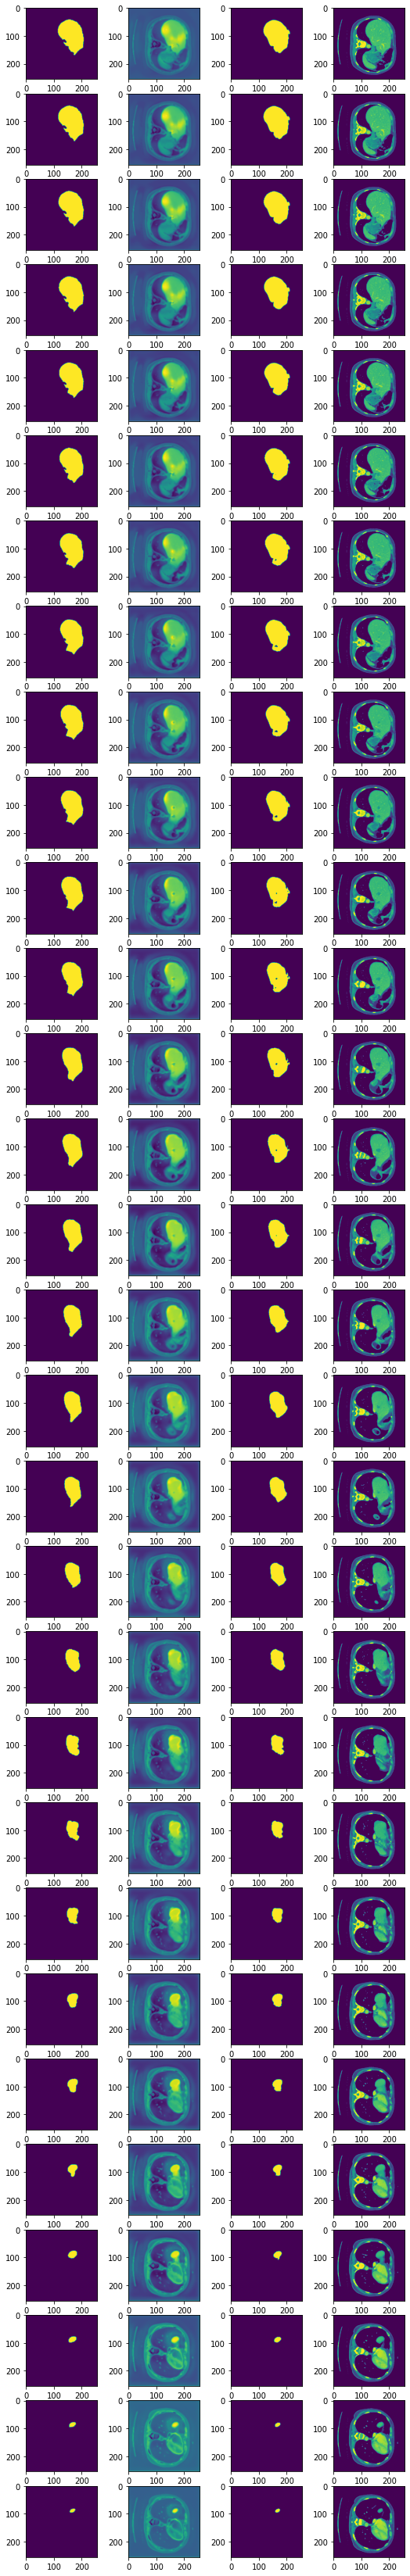

In [48]:
for i in range(30):
    plt.subplot(30, 4, 4*i+1)
    plt.imshow(label[i,:, :])
    plt.subplot(30, 4, 4*i+2)
    plt.imshow(output_model[i,:, :])
    plt.subplot(30, 4, 4*i+3)
    plt.imshow(1*(output_model[i,:, :]>0.25))
    plt.subplot(30, 4, 4*i+4)
    plt.imshow(image[i,:, :])

plt.gcf().set_size_inches(9, 60)
plt.show()

In [ ]:
counter = 4

In [ ]:
K = 24
path = '/content/drive/MyDrive/MedicalImage-Team/LiTS17/Sample Output/'


image_path = path + str(counter) + '_image.jpg'
plt.imsave(image_path, image[K,:, :])

label_path = path + str(counter) + '_label.jpg'
plt.imsave(label_path, label[K,:, :])

output_model_path = path + str(counter) + '_output_model.jpg'
plt.imsave(output_model_path, output_model[K,:, :])

# ALL Layer Test

#### Dataloader

In [ ]:
class MyCustomDataset(Dataset):
    def __init__(self, I_path, L_path, k):
        self.width = 256
        self.height = 256
        self.image_path = I_path
        self.label_path = L_path
        self.k = k

    def __len__(self):
        return len(self.image_path) # Return the size of dataset

    def __getitem__(self, idx): # Get an index
        k = self.k
        image_list = []
        label_list = []
        data_number = int(self.image_path[idx][62:-4])
        data_char = layer_properties[data_number]
        image_data = np.asarray(nib.load(self.image_path[idx]).dataobj) # Convert the .nii object to array
        label_data = np.asarray(nib.load(self.label_path[idx]).dataobj) # Convert the .nii object to array
        first_layer = 0
        last_layer = image_data.shape[2]
       

        for j in range(first_layer,last_layer+1-k,k): # Add each slice of layers with K width to the dataset
            image = image_data[:,:,j:j+k].astype('float32')  # Slice  the image
            image = cv2.resize(image, (self.width, self.height))
            image = cv2.normalize(image, None, 0, 1, cv2.NORM_MINMAX)
            image = torch.from_numpy(image)
            image = torch.unsqueeze(image,0)
            image = torch.permute(image, (0, 3, 1, 2))  # (1,512,512,k) --> (1,k,512,512)
            assert image.shape == (1,k,self.width,self.height), "Error in dim, expected (1,k,512,512)"

            label = label_data[:,:,j:j+k].astype('float32') # Slice  the label
            label = cv2.resize(label, (self.width, self.height))
            label = (label != 0) * 1
            label = torch.from_numpy(label)
            label = torch.unsqueeze(label,0)
            label = torch.permute(label, (0, 3, 1, 2)) # (1,512,512,k) --> (1,k,512,512)
            assert label.shape == (1,k,self.width,self.height), "Error in dim, expected (1,k,512,512)"
     
            image_list.append(image) # Add to the list(Dataset) 
            label_list.append(label) # Add to the list(Dataset)

        return image_list, label_list

In [ ]:
Train_size = 100
Validation_size = 30

In [ ]:
L_path_1 = ['/content/drive/MyDrive/LITS Challenge/Training Batch 1/segmentation-'+ str(i)+'.nii' for i in range(28)]
L_path_2 = ['/content/drive/MyDrive/LITS Challenge/Training Batch 2/segmentation-'+ str(i)+'.nii' for i in range(28,131)]
L_path = L_path_1 + L_path_2

L_path_Train = L_path[:Train_size]
L_path_Val = L_path[Train_size:Train_size+Validation_size]

print(len(L_path_Train),len(L_path_Val))

100 30


In [ ]:
I_path_1 = ['/content/drive/MyDrive/LITS Challenge/Training Batch 1/volume-'+ str(i)+'.nii' for i in range(28)]
I_path_2 = ['/content/drive/MyDrive/LITS Challenge/Training Batch 2/volume-'+ str(i)+'.nii' for i in range(28,131)]
I_path = I_path_1 + I_path_2

I_path_Train = I_path[:Train_size]
I_path_Val = I_path[Train_size:Train_size+Validation_size]

print(len(I_path_Train), len(I_path_Val))

100 30


In [ ]:
assert len(L_path_Train) == len(I_path_Train), "Mismatch in Train list"
assert len(L_path_Val) == len(I_path_Val), "Mismatch in Val list"

In [ ]:
k = 30
MyDataset_Train = MyCustomDataset(I_path_Train,L_path_Train,k)
My_Dataloader_Train = DataLoader(MyDataset_Train, batch_size=1, shuffle=True, num_workers=0)

MyDataset_Val = MyCustomDataset(I_path_Val,L_path_Val,k)
My_Dataloader_Val = DataLoader(MyDataset_Val, batch_size=1, shuffle=False, num_workers=0)

My_Dataloader = {
    'train' : My_Dataloader_Train,
    'val'   : My_Dataloader_Val
}

## Performance Measurement

In [ ]:
Model.eval()

for phase in ['train','val']:

        running_loss = 0.0
        running_dice = 0.0
        slice_num = 0
        # Iterate over data
                
        for batch in My_Dataloader[phase]:
            image_list, label_list = batch
            for counter in range(len(image_list)):
                image = image_list[counter]
                label = label_list[counter]
                image = image.to(device)
                label = label.to(device)
            
                optimizer.zero_grad()

                # forward
                with torch.set_grad_enabled(True):
                    output_model = Model(image.float())
                    loss = criterion(output_model.float() , label.float()) 
                    dice_score  = eval_metric(output_model.float() , label.float()) 
                
                running_loss += loss.item() * image.shape[0]
                running_dice += dice_score.item()* image.shape[0]
                slice_num += 1

        if phase == "train":
            epoch_loss = running_loss / slice_num
            epoch_dice = running_dice / slice_num
        if phase == "val":
            epoch_loss = running_loss / slice_num
            epoch_dice = running_dice / slice_num
            
        print('Phase: {} , Loss: {:.4f} , Dice: {:.4f}'.format(phase, epoch_loss, epoch_dice))

Jumping set to less than K

attention Unet

NN like VGG for classification for 3d



# Calculate Time 

In [ ]:
import time

Model.eval()

# get the start time
st_T = time.time()

counter = 0

for batch in My_Dataloader["train"]:
    image_list, label_list = batch
    # get the start time
    st = time.time()
    for i in range(len(image_list)):

        image = image_list[i]
        label = label_list[i]
        image = image.to(device)
        label = label.to(device)
    
        # forward
        with torch.set_grad_enabled(True):
            output_model = Model(image.float())


    # get the end time
    et = time.time()

    elapsed_time = (et - st)/len(image_list)
    print('Execution time:', elapsed_time, 'seconds - Epoch : ', counter)
    
    counter += 1

# get the end time
et_T = time.time()

# get the execution time
elapsed_time = et_T - st_T
print('Execution time:', elapsed_time, 'seconds')

Execution time: 0.26902187787569487 seconds - Epoch :  0
Execution time: 0.11296319961547852 seconds - Epoch :  1
Execution time: 0.1489015272108175 seconds - Epoch :  2
Execution time: 0.15100487073262533 seconds - Epoch :  3
Execution time: 0.15276304752595962 seconds - Epoch :  4
Execution time: 0.16106443779141294 seconds - Epoch :  5
Execution time: 0.18114481283270795 seconds - Epoch :  6
Execution time: 0.1607748067603921 seconds - Epoch :  7
Execution time: 0.16268325249354046 seconds - Epoch :  8
Execution time: 0.16227288522582123 seconds - Epoch :  9
Execution time: 0.1621410986956428 seconds - Epoch :  10
Execution time: 0.16193085406199995 seconds - Epoch :  11


# Calculate Number of Params 

In [ ]:
total_params = sum(p.numel() for p in Model.parameters())
print("Total number of params in Unet is", total_params)

Total number of params in Unet is 1021115


# Detector added


In [ ]:
class Model_NoSigmoid(nn.Module):
  def __init__(self):
        super().__init__()

        self.group1 = nn.Sequential(
            nn.Conv3d(1, 10, kernel_size=(2,2,2), padding=(1,1,1)),
            nn.BatchNorm3d(10),
            nn.ReLU(),
            nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(1, 2, 2))
            )
        
        self.group2 = nn.Sequential(
            nn.Conv3d(10, 40, kernel_size=(2,4,4), padding=(1,2,2), stride=(1, 2, 2)),
            nn.BatchNorm3d(40),
            nn.ReLU(),
            nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(1, 2, 2)))
        
        self.group3 = nn.Sequential(
            nn.Conv3d(40, 20, kernel_size=(2,4,4), padding=(1,2,2), stride=(1, 2, 2)),
            nn.BatchNorm3d(20),
            nn.ReLU(),
            nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(1, 2, 2)))
        
        self.group4 = nn.Sequential(
            nn.Conv3d(20, 10, kernel_size=(2,4,4), padding=(1,2,2), stride=(1, 2, 2)),
            nn.BatchNorm3d(10),
            nn.ReLU(),
            nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(1, 2, 2)))
        
        self.linear1 = nn.Linear(in_features=1200,out_features=30,bias=False)

  def forward(self, x):
        x = self.group1(x)  # (k,512,512) -> (k,256,256)
        x = self.group2(x)  # (k,256,256) -> (k,64,64)
        x = self.group3(x)  # (k,64,64)   -> (k,16,16)
        x = self.group4(x)  # (k,16,16)   -> (k,4,4)
        x = torch.flatten(x)
        x = self.linear1(x)
        #x = torch.sigmoid(x)
        return x

In [ ]:
Detector = Model_NoSigmoid().to(device)

In [ ]:
PATH = "/content/drive/MyDrive/MedicalImage-Team/LiTS17/best_Detector.pth"
Detector.load_state_dict(torch.load(PATH))

<All keys matched successfully>

#### Dataloader

In [ ]:
class MyCustomDataset(Dataset):
    def __init__(self, I_path, L_path, k):
        self.width = 256
        self.height = 256
        self.image_path = I_path
        self.label_path = L_path
        self.k = k

        # (512,512,700) --> 300 to 400 
    def __len__(self):
        return len(self.image_path) # Return the size of dataset

    def __getitem__(self, idx): # Get an index
        k = self.k #30
        image_list = []
        label_list = []
        data_number = int(self.image_path[idx][62:-4])
        data_char = layer_properties[data_number]
        image_data = np.asarray(nib.load(self.image_path[idx]).dataobj) # Convert the .nii object to array
        label_data = np.asarray(nib.load(self.label_path[idx]).dataobj) # Convert the .nii object to array
        first_layer = 1
        last_layer = image_data.shape[-1]
        #for j in range(first_layer,last_layer+1-k,k): # Add each slice of layers with K width to the dataset
        for j in range(first_layer,last_layer+1-k,1): # Add each slice of layers with K width to the dataset

            image = image_data[:,:,j:j+k].astype('float32')  # Slice  the image
            image = cv2.resize(image, (self.width, self.height))
            image = cv2.normalize(image, None, 0, 1, cv2.NORM_MINMAX)
            image = torch.from_numpy(image)
            image = torch.unsqueeze(image,0)
            image = torch.permute(image, (0, 3, 1, 2))  # (1,512,512,k) --> (1,k,512,512)
            assert image.shape == (1,k,self.width,self.height), "Error in dim, expected (1,k,512,512)"

            label = label_data[:,:,j:j+k].astype('float32') # Slice  the label
            label = cv2.resize(label, (self.width, self.height))
            label = (label != 0) * 1
            label = torch.from_numpy(label)
            label = torch.unsqueeze(label,0)
            label = torch.permute(label, (0, 3, 1, 2)) # (1,512,512,k) --> (1,k,512,512) --> (batch,1,k,512,512) --> Unet --> (batch,1,k,512,512)
            assert label.shape == (1,k,self.width,self.height), "Error in dim, expected (1,k,512,512)"
     
            image_list.append(image) # Add to the list(Dataset) 
            label_list.append(label) # Add to the list(Dataset)

        return image_list, label_list

In [ ]:
Train_size = 100
Validation_size = 30

In [ ]:
L_path_1 = ['/content/drive/MyDrive/LITS Challenge/Training Batch 1/segmentation-'+ str(i)+'.nii' for i in range(28)]
L_path_2 = ['/content/drive/MyDrive/LITS Challenge/Training Batch 2/segmentation-'+ str(i)+'.nii' for i in range(28,131)]
L_path = L_path_1 + L_path_2

L_path_Train = L_path[:Train_size]
L_path_Val = L_path[Train_size:Train_size+Validation_size]

print(len(L_path_Train),len(L_path_Val))

100 30


In [ ]:
I_path_1 = ['/content/drive/MyDrive/LITS Challenge/Training Batch 1/volume-'+ str(i)+'.nii' for i in range(28)]
I_path_2 = ['/content/drive/MyDrive/LITS Challenge/Training Batch 2/volume-'+ str(i)+'.nii' for i in range(28,131)]
I_path = I_path_1 + I_path_2

I_path_Train = I_path[:Train_size]
I_path_Val = I_path[Train_size:Train_size+Validation_size]

print(len(I_path_Train), len(I_path_Val))

100 30


In [ ]:
assert len(L_path_Train) == len(I_path_Train), "Mismatch in Train list"
assert len(L_path_Val) == len(I_path_Val), "Mismatch in Val list"

In [ ]:
k = 30
MyDataset_Train = MyCustomDataset(I_path_Train,L_path_Train,k)
My_Dataloader_Train = DataLoader(MyDataset_Train, batch_size=1, shuffle=True, num_workers=0)

MyDataset_Val = MyCustomDataset(I_path_Val,L_path_Val,k)
My_Dataloader_Val = DataLoader(MyDataset_Val, batch_size=1, shuffle=False, num_workers=0)

My_Dataloader = {
    'train' : My_Dataloader_Train,
    'val'   : My_Dataloader_Val
}

In [ ]:
for phase in ['train','val']:
    if phase == "train":
        Model.train() # Set model to training mode
    else:
        Model.eval()  # Set model to evaluate mode

    running_loss = 0.0
    running_dice = 0.0
    slice_num = 0
    # Iterate over data
            
    for batch in My_Dataloader[phase]:
        image_list, label_list = batch
        for counter in range(len(image_list)):
            image = image_list[counter]
            label = label_list[counter]
            image = image.to(device)
            label = label.to(device)

            # forward
            with torch.set_grad_enabled(True):
                flag = Detector(image.float())
                output_model = Model(image.float())
                output_model = output_model * flag.reshape((1,1,30,1,1))
                loss = criterion(output_model.float() , label.float()) 
                dice_score  = eval_metric(output_model.float() , label.float())
            
            running_loss += loss.item() * image.shape[0]
            running_dice += dice_score.item()* image.shape[0]
            slice_num += 1

    if phase == "train":
        epoch_loss = running_loss / slice_num
        epoch_dice = running_dice / slice_num
        train_result.append(epoch_dice) 
    if phase == "val":
        epoch_loss = running_loss / slice_num
        epoch_dice = running_dice / slice_num
        val_result.append(epoch_dice)
        scheduler.step(epoch_loss)
        
    if phase == "val" and (epoch_dice) > best_dice:
        best_dice = epoch_dice
        best_Model = Model
        best_epoch = epoch
        torch.save(best_Model.state_dict(), "/content/drive/MyDrive/MedicalImage-Team/LiTS17/best.pth")   
        print('saved')

    print('Phase: {} , Loss: {:.4f} , Dice: {:.4f} , Best Dice: {:.4f} , Best Epoch: {:.4f}'.format(phase, epoch_loss, epoch_dice, best_dice , best_epoch))
  